## Step 1: Download and Quickly visualize Movement Data

**Note**: If you are using JupyterLab instead of the classic Jupyter notebook, you may run into issues with loading the kepler.gl widget. The current workaround is to save the map as an interactive HTML file with the [.save_to_html()](https://docs.kepler.gl/docs/keplergl-jupyter#save_to_html) method. You can then interact with this HTML file in your favorite web browser.

In [1]:
import os
import requests
from io import StringIO
import pandas as pd

def download_csv_to_df(url, parse_dates=False):
    """
    Given a url, downloads and reads the data to a Pandas DataFrame.
    
    Args:
        url (string): includes a protocol (http), a hostname (www.example.com),
            and a file name (index. html.
        parse_dates (boolean or list) : boolean or list of columns names (str), default False.
            
    Raises:
        requests.exceptions.RequestException: An exception raised while
            handling your request.
        
    Returns:
        a Pandas DataFrame.
    """
    try:
        res = requests.get(url)
        
    except requests.exceptions.RequestException as e:
        raise SystemExit(e)

    return pd.read_csv(StringIO(res.text), parse_dates=parse_dates)

In [2]:
from keplergl import KeplerGl

# Download the sample CSV file consisting of January 1st, 2020 Movement data covering the San Francisco Bay Area.
movement_url = 'https://mapbox-movement-public-sample-dataset.s3.amazonaws.com/v0.2/daily-24h/v0.1.2/US/quadkey/total/2020/01/01/data/0230102.csv'
movement_df = download_csv_to_df(movement_url)

# Rename a few columns for clarity:
movement_df = movement_df.rename(
    columns={"xlon": "lon", "xlat": "lat"}
    )[["lon", "lat", "activity_index_total"]]

# Load an empty keplergl map
sample_z7_map = KeplerGl()

# Add movement sample csv. Kepler accepts CSV, GeoJSON or DataFrame!
sample_z7_map.add_data(data=movement_df, name='data_2')

# Optional: Save map to an html file
sample_z7_map.save_to_html(file_name='sample_z7_map.html')

# Load the kepler.gl widget below a cell
sample_z7_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to sample_z7_map.html!


KeplerGl(data={'data_2': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

## Step 2: Import Airport Metadata CSV (Downloaded from [OurAirports](https://ourairports.com/data/)).

In [3]:
# Download airport dataset
airport_url = "https://ourairports.com/data/airports.csv"
airports_df = download_csv_to_df(airport_url)

# Drop unnecessary columns
airports_df = airports_df.drop(columns=['id', 'ident', 'elevation_ft','continent',  'scheduled_service', 'gps_code', 'local_code', 'home_link', 'wikipedia_link', 'keywords'])

# Filter to US only airports
us_airports_df = airports_df[airports_df["iso_country"] == 'US']

# Filter dataframe to include only large airports
us_airports_df_large = us_airports_df[us_airports_df["type"] == "large_airport" ]
us_airports_df_large = us_airports_df_large.sort_values(by=["iso_region"])

# Inspect the first few rows of the DataFrame
us_airports_df_large.head()

,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,iata_code
42783,large_airport,Fairbanks International Airport,64.815102,-147.856003,US,US-AK,Fairbanks,FAI
42858,large_airport,Ted Stevens Anchorage International Airport,61.174400,-149.996002,US,US-AK,Anchorage,ANC
31323,large_airport,Huntsville International Carl T Jones Field,34.637199,-86.775101,US,US-AL,Huntsville,HSV
31831,large_airport,Montgomery Regional (Dannelly Field) Airport,32.300598,-86.393997,US,US-AL,Montgomery,MGM
30003,large_airport,Birmingham-Shuttlesworth International Airport,33.562901,-86.753502,US,US-AL,Birmingham,BHM


## Step 3: Convert airport latitude and longitude to Shapely Point objects

In [4]:
from shapely.geometry import Point

def coords2points(df_row):
    """
    Converts "longitude_deg" and "latitude_deg" to Shapely Point object.
  
    Args:
        df_row (Pandas DataFrame row): a particular airport (row) or a pandas.core.series.Series
            from the original airports DataFrame.
    
    Returns:
        A shapely.geometry.point object.
  """
    return Point(df_row['longitude_deg'], df_row['latitude_deg'])

# Apply the coords2points function to each row and store results in a new column 
us_airports_df_large['airport_center'] = us_airports_df_large.apply(coords2points, axis=1)
us_airports_df_large.head()

,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,iata_code,airport_center
42783,large_airport,Fairbanks International Airport,64.815102,-147.856003,US,US-AK,Fairbanks,FAI,POINT (-147.8560028 64.81510161999999)
42858,large_airport,Ted Stevens Anchorage International Airport,61.174400,-149.996002,US,US-AK,Anchorage,ANC,POINT (-149.9960021972656 61.17440032958984)
31323,large_airport,Huntsville International Carl T Jones Field,34.637199,-86.775101,US,US-AL,Huntsville,HSV,POINT (-86.775100708008 34.637199401855)
31831,large_airport,Montgomery Regional (Dannelly Field) Airport,32.300598,-86.393997,US,US-AL,Montgomery,MGM,POINT (-86.39399718999999 32.30059814)
30003,large_airport,Birmingham-Shuttlesworth International Airport,33.562901,-86.753502,US,US-AL,Birmingham,BHM,POINT (-86.75350189 33.56290054)


## Step 4: Convert center coordinates to AEQD projection, and create a circle polygon

In [5]:
from functools import partial

import pyproj
from shapely import geometry
from shapely.geometry import Point
from shapely.ops import transform

def aeqd_reproj_buffer(center, radius=1000):
    """
    Converts center coordinates to AEQD projection,
    draws a circle of given radius around the center coordinates,
    converts both polygons back to WGS84.
    
    Args:
        center (shapely.geometry Point): center coordinates of a circle.
        radius (integer): circle's radius in meters.
    
    Returns:
        A shapely.geometry Polygon object for cirlce of given radius.
    """
    # Get the latitude, longitude of the center coordinates
    lat = center.y
    long = center.x
    
    # Define the projections
    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
        lat, long
    )
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )

    # Transform center coordinates from WGS84 to AEQD
    point_transformed = transform(wgs84_to_aeqd, center)
    buffer = point_transformed.buffer(radius)
    
    # Get the polygon with lat lon coordinates
    circle_poly = transform(aeqd_to_wgs84, buffer)
    
    return  circle_poly

### Apply the aeqd_reproj_buffer function to all airport coordinates and create new columns

In [6]:
%%time

# Map the aeqd_reproj_buffer function to all airport coordinates.
us_airports_df_large["aeqd_reproj_circle"] = us_airports_df_large["airport_center"].apply(aeqd_reproj_buffer)

# Inspect the dataframe
us_airports_df_large.head()

CPU times: user 8.48 s, sys: 716 ms, total: 9.2 s
Wall time: 10.7 s


,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,iata_code,airport_center,aeqd_reproj_circle
42783,large_airport,Fairbanks International Airport,64.815102,-147.856003,US,US-AK,Fairbanks,FAI,POINT (-147.8560028 64.81510161999999),POLYGON ((-147.8348691837597 64.81510011908657...
42858,large_airport,Ted Stevens Anchorage International Airport,61.174400,-149.996002,US,US-AK,Anchorage,ANC,POINT (-149.9960021972656 61.17440032958984),POLYGON ((-149.9773496905344 61.17439904711455...
31323,large_airport,Huntsville International Carl T Jones Field,34.637199,-86.775101,US,US-AL,Huntsville,HSV,POINT (-86.775100708008 34.637199401855),POLYGON ((-86.76417026193367 34.63719891428432...
31831,large_airport,Montgomery Regional (Dannelly Field) Airport,32.300598,-86.393997,US,US-AL,Montgomery,MGM,POINT (-86.39399718999999 32.30059814),"POLYGON ((-86.38335755736951 32.3005976938058,..."
30003,large_airport,Birmingham-Shuttlesworth International Airport,33.562901,-86.753502,US,US-AL,Birmingham,BHM,POINT (-86.75350189 33.56290054),POLYGON ((-86.74270933216202 33.56290007173062...


## Step 5: Plot airport center coordinates and circle

In [7]:
from shapely.geometry import mapping
from keplergl import KeplerGl

def plot_circles_kepler(airport, to_html=False):
    """
    Plots the center and 1 km circle polygons using kepler.

    Args:
        airport (pandas.core.series.Series): an specific airport (row) from the 
            main airports DataFrame.
        to_html (boolean): if True, saves map to an html file named
            {airport_iata_code}_circle.html.
    
    Returns:
        a kepler interactive map object.
    """
    # Get the center (Shapely Point), circle (Shapely Polygon), and iata code of the airport
    circle_center = airport["airport_center"]
    circle_poly = airport["aeqd_reproj_circle"]
    iata = airport["iata_code"]

    # Define the GeoJSON object for the 1 km circle
    circle_feature = {
        "type": "Feature",
        "properties": {"name": "Circle"},
        "geometry": mapping(circle_poly)
    }

    # Define the GeoJSON object for the center of the circle
    center_feature = {
        "type": "Feature",
        "properties": {"name": "Center"},
        "geometry": mapping(circle_center)
    }
    
    # Define the Kepler map configurations
    config = {
        'version': 'v1',
        'config': {
            'mapState': {
                'latitude': airport["latitude_deg"],
                'longitude': airport["longitude_deg"],
                'zoom': 12
            }
        }
    }

    # Load the keplergl map of the circle and add center
    circle_map = KeplerGl(data={'Circle': circle_feature})
    circle_map.add_data(data=center_feature, name='Center')
    circle_map.config = config
    
    # Optional: Save map to an html file
    if to_html:
        circle_map.save_to_html(file_name=f'{iata}_circle.html')

    return circle_map

In [8]:
# Plot 1km circle polygon around San Francisco International Airport
plot_circles_kepler(us_airports_df_large[us_airports_df_large["iata_code"] == "SFO"].iloc[0], True)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to SFO_circle.html!


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 37.61899948120117, 'longitude': -122.375…

## Step 6: Generates a list of overlapping quadkeys

In [9]:
import mercantile

def generate_quadkeys(circle_poly, zoom):
    """
    Generate a list of quadkeys that overlap with an airport.
    
    Args:
        circle_poly (shapely.geometry Polygon): circle polygon object drawn 
            around an airport.
        zoom (integer): zoom level.
        
    Return:
        List of quadkeys as string
    """

    return [mercantile.quadkey(x) for x in mercantile.tiles(*circle_poly.bounds, zoom)]

### Apply generate_quadkeys function to all airports circle polygon. Generate new columns containing lists of Z18 and Z7 overlapping quadkeys


In [10]:
%%time

# Create a list of overlapping z18 quadkeys for each airport and add to a new column
us_airports_df_large['z18_quadkeys'] = us_airports_df_large.apply(lambda x: generate_quadkeys(x['aeqd_reproj_circle'], 18),axis=1)

# Create a list of overlapping z7 quadkeys for each airport and add to a new column
us_airports_df_large['z7_quadkeys'] = us_airports_df_large.apply(lambda x: generate_quadkeys(x['aeqd_reproj_circle'], 7),axis=1)

# Inspect the data
us_airports_df_large.head()

CPU times: user 653 ms, sys: 9.07 ms, total: 662 ms
Wall time: 1.02 s


,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,iata_code,airport_center,aeqd_reproj_circle,z18_quadkeys,z7_quadkeys
42783,large_airport,Fairbanks International Airport,64.815102,-147.856003,US,US-AK,Fairbanks,FAI,POINT (-147.8560028 64.81510161999999),POLYGON ((-147.8348691837597 64.81510011908657...,"[020101303321213131, 020101303321213133, 02010...",[0201013]
42858,large_airport,Ted Stevens Anchorage International Airport,61.174400,-149.996002,US,US-AK,Anchorage,ANC,POINT (-149.9960021972656 61.17440032958984),POLYGON ((-149.9773496905344 61.17439904711455...,"[020121012121001032, 020121012121001210, 02012...",[0201210]
31323,large_airport,Huntsville International Carl T Jones Field,34.637199,-86.775101,US,US-AL,Huntsville,HSV,POINT (-86.775100708008 34.637199401855),POLYGON ((-86.76417026193367 34.63719891428432...,"[032002122122120300, 032002122122120302, 03200...",[0320021]
31831,large_airport,Montgomery Regional (Dannelly Field) Airport,32.300598,-86.393997,US,US-AL,Montgomery,MGM,POINT (-86.39399718999999 32.30059814),"POLYGON ((-86.38335755736951 32.3005976938058,...","[032002323022113210, 032002323022113212, 03200...",[0320023]
30003,large_airport,Birmingham-Shuttlesworth International Airport,33.562901,-86.753502,US,US-AL,Birmingham,BHM,POINT (-86.75350189 33.56290054),POLYGON ((-86.74270933216202 33.56290007173062...,"[032002302120110302, 032002302120110320, 03200...",[0320023]


## Step 7: Download Movement Data and Filter to Include Only Relevant Z18 Quadkey Entries
The following step demonstrates how to download Z7 quadkey data before further reducing the DataFrame to include only entries of Z18 quadkey that overlap with the 1 km circles. 

In [11]:
import os
import requests
from datetime import datetime, timedelta

def download_sample_data_to_df(start_date, end_date, z7_quadkey_list, local_dir, verbose=True):
    """
    Downloads Movement z7 quadkey CSV files to a local dir and reads
    Read the CSV file into a Pandas DataFrame. This DataFrame contains
    **ALL** Z18 quadkey data in this Z7 quadkey.
    
    Args:
        start_date (string): start date as YYYY-MM-DD string.
        end_date (string): end date as YYYY-MM-DD string.
        z7_quadkey_list (list): list of zoom 7 quadkeys as string.
        local_dir (string): local directory to store downloaded sample data.
        verbose (boolean): print download status.
    
    Raises:
        requests.exceptions.RequestException: An exception raised while
            handling your request.
        
    Returns:
        a Pandas DataFrame consists of Z7 quadkey data. DataFrame contains
        **ALL** Z18 quadkey data in this Z7 quadkey.
    
    """

    bucket = "mapbox-movement-public-sample-dataset"
    
    # Generate range of dates between start and end date in %Y-%m-%d string format
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    num_days = int((end - start).days)
    days_range = num_days + 1
    date_range = [(start + timedelta(n)).strftime('%Y-%m-%d') for n in range(days_range)]

    sample_data = []
    for z7_quadkey in z7_quadkey_list:
        for i in range(len(date_range)):
            yr, month, date = date_range[i].split('-')
            url = f"https://{bucket}.s3.amazonaws.com/v0.2/daily-24h/v2.0/US/quadkey/total/2020/{month}/{date}/data/{z7_quadkey}.csv"
    
            if not os.path.isdir(os.path.join(local_dir, month, date)):
                os.makedirs(os.path.join(local_dir, month, date))

            local_path = os.path.join(local_dir, month, date, f'{z7_quadkey}.csv')

            if verbose:
                print (z7_quadkey, month, date)
                print (f'local_path : {local_path}')

            try:
                res = requests.get(url)
                df = pd.read_csv(StringIO(res.text))
                convert_dict = {'agg_day_period': 'datetime64[ns]', 'activity_index_total': float, 'geography': str} 
                df = df.astype(convert_dict)
                # Keep leading zeros and save as string
                df['z18_quadkey'] = df.apply(lambda x: x['geography'].zfill(18), axis=1).astype('str')
                df['z7_quadkey'] = df.apply(lambda x: x['geography'][:6].zfill(7), axis=1).astype('str')
                
                sample_data.append(df)
                df.to_csv(local_path, index=False)

            except requests.exceptions.RequestException as e:
                raise SystemExit(e)

            if verbose:
                print (f'Download completed for {z7_quadkey} over date range {start_dt} to {end_dt}')


    return pd.concat(sample_data)

#### Try using this function to download one day's worth of data for SFO and DEN 

In [12]:
%%time

# Tweak the following set of parameters to include broader time frame or more airports
start_dt_str = "2020-01-01"
end_dt_str = "2020-01-02"

# San Francisco International Airport
sfo = us_airports_df_large[us_airports_df_large["iata_code"] == "SFO"].iloc[0]
# Denver International Airport
den = us_airports_df_large[us_airports_df_large['name'].str.contains("Denver")].iloc[0]

# Add these two airports
airports = [sfo, den]

# Creates a list of z7 quadkeys to download
z7_quadkeys_to_download = []
for airport in airports:
    for z7_quadkey in airport["z7_quadkeys"]:
        z7_quadkeys_to_download.append(z7_quadkey)

# Define a list to append all newly created DataFrames
sample_data_airports = []
sample_data_airports = []
for z7 in z7_quadkeys_to_download:
    local_directory = os.path.join(os.getcwd(), f'sample_data_{z7}')
    print ([z7])
    print (local_directory)

    # Run the download script
    sample_data_airports.append(download_sample_data_to_df(start_dt_str, end_dt_str, [z7], local_directory, False))

# Create a DataFrame of all z7 quadkey activity data
sample_data_airports_df = pd.concat(sample_data_airports).sort_values(by=['agg_day_period', 'z18_quadkey'])

['0230102']
/Users/virginiang/Documents/Movement/BlogPostStaging/sample_data_0230102
['0231010']
/Users/virginiang/Documents/Movement/BlogPostStaging/sample_data_0231010
CPU times: user 6.42 s, sys: 327 ms, total: 6.75 s
Wall time: 26.4 s


In [13]:
# Inspect the DataFrame
sample_data_airports_df

,geography,xlon,xlat,bounds,agg_day_period,activity_index_total,z18_quadkey,z7_quadkey
6287,23010200301013202,-123.276901,38.533665,"-123.277587890625,38.533127435052755,-123.2762...",2020-01-01,0.032290,023010200301013202,0230102
13067,23010200333111133,-123.047562,38.337886,"-123.04824829101562,38.33734763569314,-123.046...",2020-01-01,0.042025,023010200333111133,0230102
25001,23010200333111302,-123.051682,38.335732,"-123.0523681640625,38.33519326105275,-123.0509...",2020-01-01,0.019516,023010200333111302,0230102
9497,23010200333111330,-123.048935,38.334655,"-123.04962158203125,38.33411604971081,-123.048...",2020-01-01,0.024059,023010200333111330,0230102
7542,23010200333113111,-123.047562,38.332500,"-123.04824829101562,38.33196157898414,-123.046...",2020-01-01,0.024152,023010200333113111,0230102
...,...,...,...,...,...,...,...,...
4006,23101033320001133,-104.392776,38.955671,"-104.39346313476562,38.95513722542956,-104.392...",2020-01-02,0.118031,023101033320001133,0231010
17582,23101033321210201,-104.302139,38.920421,"-104.30282592773438,38.91988697357693,-104.301...",2020-01-02,0.060282,023101033321210201,0231010
32472,23101033322202310,-104.405136,38.843451,"-104.40582275390625,38.842916524822385,-104.40...",2020-01-02,0.020763,023101033322202310,0231010
6627,23101033323131301,-104.241714,38.869117,"-104.24240112304688,38.86858260508893,-104.241...",2020-01-02,0.091151,023101033323131301,0231010


#### Filter the DataFrame to include only entries of Z18 quadkey that overlap with the 1 km circle


In [14]:
# Filter DataFrame to include data from SFO z7 quadkeys only. Excludes DEN z7 quadkey data.
sample_data_sfo = []
for z7_quadkey in sfo["z7_quadkeys"]:
    sample_data_sfo.append(sample_data_airports_df[sample_data_airports_df["z7_quadkey"] == z7_quadkey])

# Create a DataFrame for all SFO activity data
sample_data_df_sfo = pd.concat(sample_data_sfo)

In [15]:
# Filter the DataFrame to include only entries of Z18 quadkey that overlap with the 1 km circle
z18_sample_data_sfo_df = sample_data_df_sfo[sample_data_df_sfo["z18_quadkey"].isin([z18_qk for z18_qk in sfo["z18_quadkeys"]])]
z18_sample_data_sfo_df

,geography,xlon,xlat,bounds,agg_day_period,activity_index_total,z18_quadkey,z7_quadkey
12272,23010221113120220,-122.387009,37.624565,"-122.3876953125,37.62402129571884,-122.3863220...",2020-01-01,0.057848,023010221113120220,0230102
18628,23010221113121200,-122.376022,37.626740,"-122.376708984375,37.62619664960864,-122.37533...",2020-01-01,0.061104,023010221113121200,0230102
22397,23010221113122003,-122.385635,37.621302,"-122.38632202148438,37.62075814551955,-122.384...",2020-01-01,0.026219,023010221113122003,0230102
10313,23010221113122020,-122.387009,37.620214,"-122.3876953125,37.61967039695653,-122.3863220...",2020-01-01,0.138171,023010221113122020,0230102
7938,23010221113122022,-122.387009,37.619127,"-122.3876953125,37.618582632478805,-122.386322...",2020-01-01,0.131442,023010221113122022,0230102
...,...,...,...,...,...,...,...,...
22251,23010221113300003,-122.385635,37.612600,"-122.38632202148438,37.61205571141281,-122.384...",2020-01-02,0.024878,023010221113300003,0230102
24961,23010221113300010,-122.384262,37.613687,"-122.38494873046875,37.61314357137536,-122.383...",2020-01-02,0.026957,023010221113300010,0230102
43107,23010221113300012,-122.384262,37.612600,"-122.38494873046875,37.61205571141281,-122.383...",2020-01-02,0.041378,023010221113300012,0230102
6907,23010221113300013,-122.382889,37.612600,"-122.38357543945312,37.61205571141281,-122.382...",2020-01-02,0.014645,023010221113300013,0230102


## Step 8: Download airport relevant z18 sample data
**Note**: A year's worth of data for four airports take quite a bit of time to download and read into a single DataFrame. Below is a shortcut to download the CSV files, consist of **2020-01-01** to **2020-12-31** data from Z18 quadkeys that overlap with each airport's 1 km circle.

#### Load Movement 2020 SFO relevant z18 sample data

In [16]:
%%time
# Find the San Francisco International Airport row in the DataFrame
sfo = us_airports_df_large[us_airports_df_large["iata_code"] == "SFO"].iloc[0]

# Define the url of SFO's pre-processed CSV file
z18_sample_data_sfo_url = 'https://mapbox-movement-public-sample-dataset.s3.amazonaws.com/airports_dataset/data/z18_sample_data_sfo.csv'

# Download sample data for sfo and read into a DataFrame. Parse agg_day_period as datetime object
z18_sample_data_sfo_df = download_csv_to_df(z18_sample_data_sfo_url, parse_dates=['agg_day_period'])

# Add airport iata code to help identify each airport when we're plotting statistics later on
z18_sample_data_sfo_df["iata"] = sfo["iata_code"]

# Sort the DataFrame by date and inspect the DataFrame
z18_sample_data_sfo_df = z18_sample_data_sfo_df.sort_values(by=['agg_day_period', 'z18_quadkey'])
z18_sample_data_sfo_df

CPU times: user 89.2 ms, sys: 13 ms, total: 102 ms
Wall time: 1.94 s


,geography,xlon,xlat,bounds,agg_day_period,activity_index_total,z18_quadkey,z7_quadkey,iata
0,23010221113120220,-122.387009,37.624565,"-122.3876953125,37.62402129571884,-122.3863220...",2020-01-01,0.057848,23010221113120220,230102,SFO
1,23010221113121200,-122.376022,37.626740,"-122.376708984375,37.62619664960864,-122.37533...",2020-01-01,0.061104,23010221113121200,230102,SFO
2,23010221113122003,-122.385635,37.621302,"-122.38632202148438,37.62075814551955,-122.384...",2020-01-01,0.026219,23010221113122003,230102,SFO
3,23010221113122020,-122.387009,37.620214,"-122.3876953125,37.61967039695653,-122.3863220...",2020-01-01,0.138171,23010221113122020,230102,SFO
4,23010221113122022,-122.387009,37.619127,"-122.3876953125,37.618582632478805,-122.386322...",2020-01-01,0.131442,23010221113122022,230102,SFO
...,...,...,...,...,...,...,...,...,...
6424,23010221113122222,-122.387009,37.614775,"-122.3876953125,37.61423141542417,-122.3863220...",2020-12-31,0.041861,23010221113122222,230102,SFO
6425,23010221113122223,-122.385635,37.614775,"-122.38632202148438,37.61423141542417,-122.384...",2020-12-31,0.091014,23010221113122223,230102,SFO
6426,23010221113122230,-122.384262,37.615863,"-122.38494873046875,37.61531924355908,-122.383...",2020-12-31,0.034250,23010221113122230,230102,SFO
6427,23010221113122302,-122.381516,37.616951,"-122.3822021484375,37.61640705577993,-122.3808...",2020-12-31,0.016163,23010221113122302,230102,SFO


#### Load Movement 2020 DEN relevant z18 sample data

In [17]:
%%time

# Find the Denver International Airport row in the DataFrame
den = us_airports_df_large[us_airports_df_large['name'].str.contains("Denver")].iloc[0]

# Define the url of DEN's pre-processed CSV file
z18_sample_data_den_url = 'https://mapbox-movement-public-sample-dataset.s3.amazonaws.com/airports_dataset/data/z18_sample_data_den.csv'

# Download sample data for den and read into a DataFrame. Parse agg_day_period as datetime object
z18_sample_data_den_df = download_csv_to_df(z18_sample_data_den_url, parse_dates=['agg_day_period'])

# Add airport iata code to help identify each airport when we're plotting statistics later on
z18_sample_data_den_df["iata"] = den["iata_code"]

# Inspect the DataFrame
z18_sample_data_den_df

CPU times: user 97.2 ms, sys: 22.7 ms, total: 120 ms
Wall time: 1.8 s


,geography,xlon,xlat,bounds,agg_day_period,activity_index_total,z18_quadkey,z7_quadkey,iata
0,23101031000313133,-104.678421,39.863898,"-104.67910766601562,39.863371338285305,-104.67...",2020-01-01,0.041732,23101031000313133,231010,DEN
1,23101031000313311,-104.678421,39.862844,"-104.67910766601562,39.862317226243846,-104.67...",2020-01-01,0.031883,23101031000313311,231010,DEN
2,23101031000313332,-104.679794,39.859682,"-104.68048095703125,39.85915479295669,-104.679...",2020-01-01,0.075775,23101031000313332,231010,DEN
3,23101031000313333,-104.678421,39.859682,"-104.67910766601562,39.85915479295669,-104.677...",2020-01-01,0.105819,23101031000313333,231010,DEN
4,23101031000331110,-104.679794,39.858628,"-104.68048095703125,39.85810061614039,-104.679...",2020-01-01,0.099329,23101031000331110,231010,DEN
...,...,...,...,...,...,...,...,...,...
19338,23101031001220312,-104.668808,39.853357,"-104.66949462890625,39.852829489159426,-104.66...",2020-12-31,0.039587,23101031001220312,231010,DEN
19339,23101031001220320,-104.671555,39.852302,"-104.6722412109375,39.85177521518409,-104.6708...",2020-12-31,0.053349,23101031001220320,231010,DEN
19340,23101031001221000,-104.666061,39.858628,"-104.666748046875,39.85810061614039,-104.66537...",2020-12-31,0.018437,23101031001221000,231010,DEN
19341,23101031001221002,-104.666061,39.857574,"-104.666748046875,39.857046423130654,-104.6653...",2020-12-31,0.087670,23101031001221002,231010,DEN


#### Load Movement 2020 DFW relevant z18 sample data

In [18]:
%%time

# Find the Dallas/Fort Worth International Airport row in the DataFrame
dfw = us_airports_df_large[us_airports_df_large['name'].str.contains("Dallas Fort Worth International Airport")].iloc[0]

# Define the url of DFW's pre-processed CSV file
z18_sample_data_dfw_url = 'https://mapbox-movement-public-sample-dataset.s3.amazonaws.com/airports_dataset/data/z18_sample_data_dfw.csv'

# Download sample data for dfw and read into a DataFrame. Parse agg_day_period as datetime object
z18_sample_data_dfw_df = download_csv_to_df(z18_sample_data_dfw_url, parse_dates=['agg_day_period'])

# Add airport iata code to help identify each airport when we're plotting statistics later on
z18_sample_data_dfw_df["iata"] = dfw["iata_code"]

# Inspect the DataFrame
z18_sample_data_dfw_df

CPU times: user 180 ms, sys: 50.3 ms, total: 230 ms
Wall time: 7.89 s


,geography,xlon,xlat,bounds,agg_day_period,activity_index_total,z18_quadkey,z7_quadkey,iata
0,23112321133112102,-97.047043,32.905533,"-97.0477294921875,32.90495631913752,-97.046356...",2020-01-01,0.040251,23112321133112102,231123,DFW
1,23112321133112103,-97.045670,32.905533,"-97.04635620117188,32.90495631913752,-97.04498...",2020-01-01,0.117351,23112321133112103,231123,DFW
2,23112321133112112,-97.044296,32.905533,"-97.04498291015625,32.90495631913752,-97.04360...",2020-01-01,0.180047,23112321133112112,231123,DFW
3,23112321133112113,-97.042923,32.905533,"-97.04360961914062,32.90495631913752,-97.04223...",2020-01-01,0.055763,23112321133112113,231123,DFW
4,23112321133112121,-97.045670,32.904380,"-97.04635620117188,32.90380333374559,-97.04498...",2020-01-01,0.217268,23112321133112121,231123,DFW
...,...,...,...,...,...,...,...,...,...
41877,23112321133133001,-97.040176,32.888237,"-97.04086303710938,32.88765996207896,-97.03948...",2020-12-31,0.020824,23112321133133001,231123,DFW
41878,23112321133133010,-97.038803,32.888237,"-97.03948974609375,32.88765996207896,-97.03811...",2020-12-31,0.100807,23112321133133010,231123,DFW
41879,23112321133133011,-97.037430,32.888237,"-97.03811645507812,32.88765996207896,-97.03674...",2020-12-31,0.187178,23112321133133011,231123,DFW
41880,23112321133133100,-97.036057,32.888237,"-97.0367431640625,32.88765996207896,-97.035369...",2020-12-31,0.148946,23112321133133100,231123,DFW


#### Load Movement 2020 IAD relevant z18 sample data

In [19]:
%%time
# Find the Dullus International Aiport row in the DataFrame
iad = us_airports_df_large[us_airports_df_large['name'].str.contains("Washington Dulles International Airport")].iloc[0]

# Define the url of IAD's pre-processed CSV file
z18_sample_data_iad_url = 'https://mapbox-movement-public-sample-dataset.s3.amazonaws.com/airports_dataset/data/z18_sample_data_iad.csv'

# Download sample data for iad and read into a DataFrame. Parse agg_day_period as datetime object
z18_sample_data_iad_df = download_csv_to_df(z18_sample_data_iad_url, parse_dates=['agg_day_period'])

# Add airport iata code to help identify each airport when we're plotting statistics later on
z18_sample_data_iad_df["iata"] = iad["iata_code"]

# Inspect the DataFrame
z18_sample_data_iad_df

CPU times: user 64.2 ms, sys: 14.7 ms, total: 78.9 ms
Wall time: 1.08 s


,geography,xlon,xlat,bounds,agg_day_period,activity_index_total,z18_quadkey,z7_quadkey,iata
0,32010023330103101,-77.457047,38.950331,"-77.45773315429688,38.94979740456155,-77.45635...",2020-01-01,0.033569,32010023330103101,320100,IAD
1,32010023330103112,-77.455673,38.949263,"-77.45635986328125,38.94872939211094,-77.45498...",2020-01-01,0.023834,32010023330103112,320100,IAD
2,32010023330103113,-77.454300,38.949263,"-77.45498657226562,38.94872939211094,-77.45361...",2020-01-01,0.040046,32010023330103113,320100,IAD
3,32010023330103130,-77.455673,38.948195,"-77.45635986328125,38.947661363568294,-77.4549...",2020-01-01,0.035773,32010023330103130,320100,IAD
4,32010023330103131,-77.454300,38.948195,"-77.45498657226562,38.947661363568294,-77.4536...",2020-01-01,0.031927,32010023330103131,320100,IAD
...,...,...,...,...,...,...,...,...,...
10367,32010023330112212,-77.450180,38.944991,"-77.45086669921875,38.944457181389424,-77.4494...",2020-12-31,0.038573,32010023330112212,320100,IAD
10368,32010023330112213,-77.448807,38.944991,"-77.44949340820312,38.944457181389424,-77.4481...",2020-12-31,0.027191,32010023330112213,320100,IAD
10369,32010023330112300,-77.447433,38.946059,"-77.4481201171875,38.9455252582074,-77.4467468...",2020-12-31,0.049599,32010023330112300,320100,IAD
10370,32010023330112301,-77.446060,38.946059,"-77.44674682617188,38.9455252582074,-77.445373...",2020-12-31,0.058394,32010023330112301,320100,IAD


## Step 9: Generate Statistics

#### Step 9a. Generate Statitics for SFO

In [20]:
# Calculate the aggregated activity across all z18 quadkeys per day for SFO and construct a DataFrame with date as the index
z18_sample_df = z18_sample_data_sfo_df.copy()
sum_data = z18_sample_df.groupby(['agg_day_period']).sum()['activity_index_total']

sfo_ai_stats_df = pd.DataFrame(sum_data).reset_index().rename(columns={'activity_index_total':'sum_ai_daily'})
sfo_ai_stats_df = sfo_ai_stats_df.set_index('agg_day_period')

# Inspect the DataFrame
sfo_ai_stats_df

,sum_ai_daily
agg_day_period,
2020-01-01,5.029205
2020-01-02,6.479782
2020-01-03,5.924845
2020-01-04,5.373597
2020-01-05,6.844148
...,...
2020-12-27,0.985882
2020-12-28,0.959070
2020-12-29,0.816198


In [21]:
from datetime import timedelta, date

# Find the timestamp for Jan 4 to Jan 31, 2020 and generate a list of dates
jan_start_date = datetime.strptime('2020-01-04', "%Y-%m-%d")
jan_end_date = datetime.strptime('2020-01-31', "%Y-%m-%d")
jan_dates = pd.date_range(jan_start_date, jan_end_date, freq='D')

# Compute the aggregated activity from Jan 4 to Jan 31, 2020 for SFO
sfo_sum_ai_Jan_2020 = sfo_ai_stats_df[sfo_ai_stats_df.index.isin([x for x in jan_dates])].sum()['sum_ai_daily']
sfo_ai_stats_df["sum_ai_Jan_2020"] = sfo_sum_ai_Jan_2020

# Normalize the daily sum of activity by the total sum of activity from Jan 4 to Jan 31, 2020, add to DataFrame.
sfo_ai_stats_df["normalized_sum"] = 28 * sfo_ai_stats_df["sum_ai_daily"] / sfo_sum_ai_Jan_2020

# Inspect the DataFrame
sfo_ai_stats_df

,sum_ai_daily,sum_ai_Jan_2020,normalized_sum
agg_day_period,,,
2020-01-01,5.029205,166.878458,0.843834
2020-01-02,6.479782,166.878458,1.087222
2020-01-03,5.924845,166.878458,0.994111
2020-01-04,5.373597,166.878458,0.901619
2020-01-05,6.844148,166.878458,1.148358
...,...,...,...
2020-12-27,0.985882,166.878458,0.165418
2020-12-28,0.959070,166.878458,0.160919
2020-12-29,0.816198,166.878458,0.136947


In [22]:
# Compute the 7-day rolling average of the daily aggregated activity add to the DataFrame
sfo_ai_stats_df["sum_ai_daily_rolling_avg"] = sfo_ai_stats_df["sum_ai_daily"].rolling(window=7).mean()

# Inspect the DataFrame
sfo_ai_stats_df

,sum_ai_daily,sum_ai_Jan_2020,normalized_sum,sum_ai_daily_rolling_avg
agg_day_period,,,,
2020-01-01,5.029205,166.878458,0.843834,NaN
2020-01-02,6.479782,166.878458,1.087222,NaN
2020-01-03,5.924845,166.878458,0.994111,NaN
2020-01-04,5.373597,166.878458,0.901619,NaN
2020-01-05,6.844148,166.878458,1.148358,NaN
...,...,...,...,...
2020-12-27,0.985882,166.878458,0.165418,0.871589
2020-12-28,0.959070,166.878458,0.160919,0.856824
2020-12-29,0.816198,166.878458,0.136947,0.850811


In [23]:
# Compute the 7-day rolling average of the normalized daily aggregated activity
sfo_ai_stats_df["norm_sum_rolling_avg"] = sfo_ai_stats_df["sum_ai_daily"].rolling(window=7).mean()

# Inspect the DataFrame
sfo_ai_stats_df

,sum_ai_daily,sum_ai_Jan_2020,normalized_sum,sum_ai_daily_rolling_avg,norm_sum_rolling_avg
agg_day_period,,,,,
2020-01-01,5.029205,166.878458,0.843834,NaN,NaN
2020-01-02,6.479782,166.878458,1.087222,NaN,NaN
2020-01-03,5.924845,166.878458,0.994111,NaN,NaN
2020-01-04,5.373597,166.878458,0.901619,NaN,NaN
2020-01-05,6.844148,166.878458,1.148358,NaN,NaN
...,...,...,...,...,...
2020-12-27,0.985882,166.878458,0.165418,0.871589,0.871589
2020-12-28,0.959070,166.878458,0.160919,0.856824,0.856824
2020-12-29,0.816198,166.878458,0.136947,0.850811,0.850811


### Step 9b. Generate statistics for all four airports: SFO, DEN, DFW, IAD

In [24]:
from datetime import timedelta, datetime

def generate_airport_stats(airport_z18_sample_df,
                           label='iata',
                           normalizer_start_date='2020-01-04',
                           normalizer_end_date='2020-01-31'):
    """
    Given a Pandas DataFrame consists of an airport's Movement sample data,
    generate a new Pandas DataFrame consists of the aggregated activity index,
    7-day rolling average of aggregated activity, normalized activity index,
    7-day rolling average of normalized activity.
    
    
    Args:
        airport_z18_sample_df (Pandas DataFrame): DataFrame consists of data from 
            z18 quadkey that overlaps with 1 km circle. Should include "iata" of the airport as a column.
        label (string): 
            
    Raises:
        ValueError: If 'iata' column is missing from the airport_z18_sample_df DataFrame.
        TypeError: If 'agg_day_period' column is datetime.datetime.
        
    Returns:
        airport_stats_ai_df(Pandas DataFrame): DataFrame consists of airport statistics.
    """
    
    if label == 'iata' and 'iata' not in airport_z18_sample_df.columns:
        raise ValueError('Missing iata column in the Pandas DataFrame')
        
    if not isinstance(airport_z18_sample_df['agg_day_period'].iloc[0], datetime):
        errstr = "agg_day_period is of type " + type(airport_z18_sample_df['agg_day_period'].iloc[0]).__name__ + \
                ", should be of datetime.datetime object"
        raise TypeError(errstr)
        
    if label == 'iata':
        col_label = airport_z18_sample_df['iata'].iloc[0]
    else:
        col_label = label

    airport_stats_ai_df = airport_z18_sample_df.copy()

    # Calculate the aggregated AI per day
    airport_stats_ai_df = airport_stats_ai_df.groupby(['agg_day_period']).sum()["activity_index_total"].reset_index()
    airport_stats_ai_df = airport_stats_ai_df.rename(columns={'activity_index_total': f'sum_ai_daily_{col_label}'})
    airport_stats_ai_df = airport_stats_ai_df.set_index('agg_day_period')

    # Create a list of dates between start_date and end_date
    jan_start = datetime.strptime(normalizer_start_date, "%Y-%m-%d")
    jan_end = datetime.strptime(normalizer_end_date, "%Y-%m-%d")
    jan_dates = pd.date_range(jan_start, jan_end, freq='D')


    sum_ai_Jan_2020 = airport_stats_ai_df[airport_stats_ai_df.index.isin([x for x in jan_dates])].sum()[f'sum_ai_daily_{col_label}']
    airport_stats_ai_df[f'normalized_sum_{col_label}'] = 28 * airport_stats_ai_df[f'sum_ai_daily_{col_label}'] / sum_ai_Jan_2020
    airport_stats_ai_df[f'sum_ai_daily_rolling_avg_{col_label}'] = airport_stats_ai_df[f'sum_ai_daily_{col_label}'].rolling(window=7).mean()
    airport_stats_ai_df[f'norm_sum_rolling_avg_{col_label}'] = airport_stats_ai_df[f'normalized_sum_{col_label}'].rolling(window=7).mean()

    return airport_stats_ai_df

In [25]:
import matplotlib.pyplot as plt

# Generate adjusted daily stats for all four airport, append them to a list and create a large DataFrame
all_airports_stats_ai = []
airport_z18_sample_dfList = [z18_sample_data_sfo_df, z18_sample_data_den_df, z18_sample_data_dfw_df, z18_sample_data_iad_df]

for airport_z18_sample_df in airport_z18_sample_dfList:
    all_airports_stats_ai.append(generate_airport_stats(airport_z18_sample_df))
all_airports_stats_ai_df = pd.concat(all_airports_stats_ai, axis=1)

# Append airport iata code to column names, so that one airport's statistic is distinguishable from another.
all_airports_stats_ai_df

,sum_ai_daily_SFO,normalized_sum_SFO,sum_ai_daily_rolling_avg_SFO,norm_sum_rolling_avg_SFO,sum_ai_daily_DEN,normalized_sum_DEN,sum_ai_daily_rolling_avg_DEN,norm_sum_rolling_avg_DEN,sum_ai_daily_DFW,normalized_sum_DFW,sum_ai_daily_rolling_avg_DFW,norm_sum_rolling_avg_DFW,sum_ai_daily_IAD,normalized_sum_IAD,sum_ai_daily_rolling_avg_IAD,norm_sum_rolling_avg_IAD
agg_day_period,,,,,,,,,,,,,,,,
2020-01-01,5.029205,0.843834,NaN,NaN,8.947746,1.050325,NaN,NaN,19.653429,0.726105,NaN,NaN,5.647360,0.923460,NaN,NaN
2020-01-02,6.479782,1.087222,NaN,NaN,9.970132,1.170337,NaN,NaN,25.818333,0.953871,NaN,NaN,6.129980,1.002378,NaN,NaN
2020-01-03,5.924845,0.994111,NaN,NaN,8.335129,0.978414,NaN,NaN,23.116370,0.854045,NaN,NaN,5.943424,0.971872,NaN,NaN
2020-01-04,5.373597,0.901619,NaN,NaN,7.386913,0.867108,NaN,NaN,20.752611,0.766715,NaN,NaN,5.687044,0.929949,NaN,NaN
2020-01-05,6.844148,1.148358,NaN,NaN,7.805538,0.916248,NaN,NaN,24.350000,0.899622,NaN,NaN,6.685583,1.093231,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.985882,0.165418,0.871589,0.146241,5.144558,0.603891,4.906665,0.575966,11.627733,0.429592,10.096193,0.373009,1.824389,0.298325,1.757398,0.287371
2020-12-28,0.959070,0.160919,0.856824,0.143764,6.186331,0.726178,5.097324,0.598346,12.718722,0.469899,10.338095,0.381946,1.608694,0.263055,1.755211,0.287013
2020-12-29,0.816198,0.136947,0.850811,0.142755,5.280610,0.619861,5.112940,0.600179,10.895410,0.402536,10.337128,0.381910,1.534017,0.250843,1.734220,0.283581


Text(0.5, 1.0, 'Aggregated Daily Activity Index: SFO, DEN, DFW, IAD')

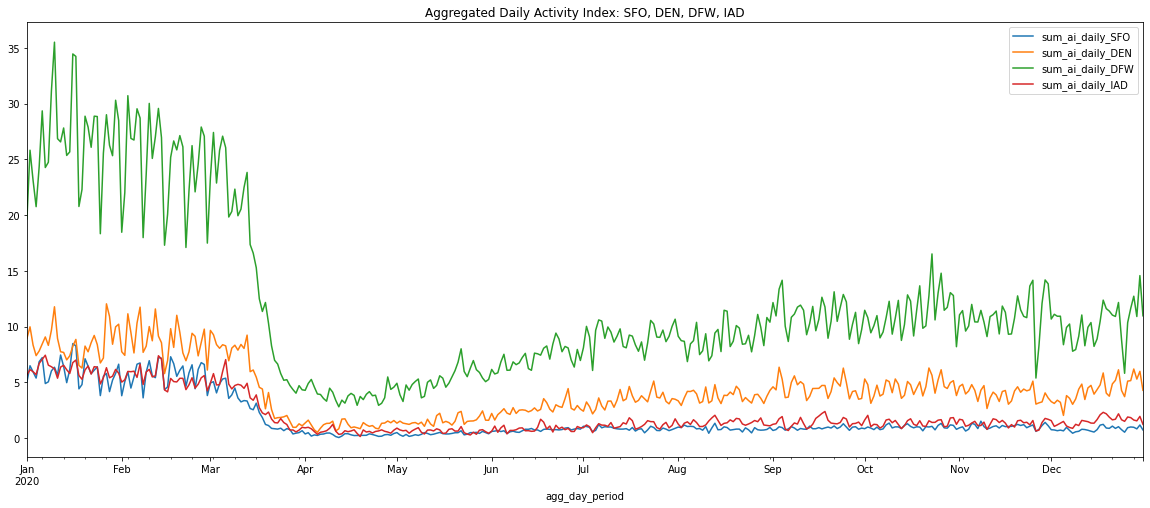

In [26]:
## Plot daily aggregated AI for all four airports
all_airports_sum = all_airports_stats_ai_df[[sum_col for sum_col in all_airports_stats_ai_df.columns if 'sum_ai_daily' in sum_col and 'rolling' not in sum_col]]

# Use the default colors from color cycle. You can also pass in a list of colors to the color parameter.
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
all_airports_sum.plot(color=colors, figsize=(20, 8))
plt.legend(all_airports_sum.columns, loc='upper right')
plt.title('Aggregated Daily Activity Index: SFO, DEN, DFW, IAD')

Text(0.5, 1.0, '7-day Rolling Average of Aggregated Daily Activity Index: SFO, DEN, DFW, IAD')

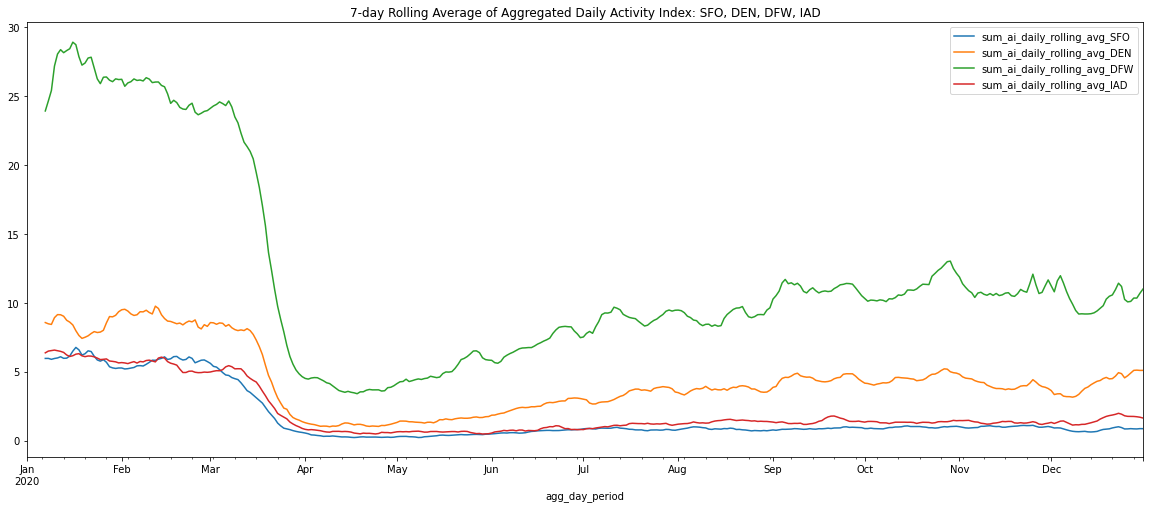

In [27]:
all_airports_sum_rolling = all_airports_stats_ai_df[[sum_col for sum_col in all_airports_stats_ai_df.columns if 'sum_ai_daily_rolling' in sum_col]]
all_airports_sum_rolling.plot(figsize=(20, 8))
plt.legend(all_airports_sum_rolling.columns, loc='upper right')
plt.title('7-day Rolling Average of Aggregated Daily Activity Index: SFO, DEN, DFW, IAD')

Text(0.5, 1.0, 'Normalized Aggregated Daily Activity Index: SFO, DEN, DFW, IAD')

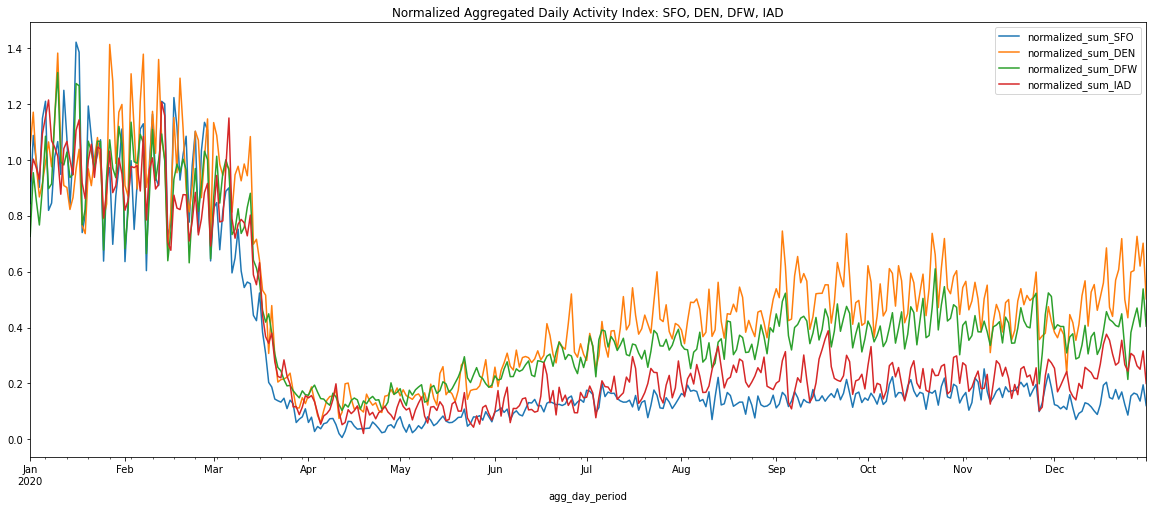

In [28]:
## Plot normalized daily aggregated AI for all four airports
all_airports_norm = all_airports_stats_ai_df[[sum_col for sum_col in all_airports_stats_ai_df.columns if 'normalized_sum' in sum_col and 'rolling' not in sum_col]]
all_airports_norm.plot(figsize=(20, 8))
plt.legend(all_airports_norm.columns, loc='upper right')
plt.title('Normalized Aggregated Daily Activity Index: SFO, DEN, DFW, IAD')

Text(0.5, 1.0, '7-day Rolling Average of Normalized Aggregated Daily Activity Index: SFO, DEN, DFW, IAD')

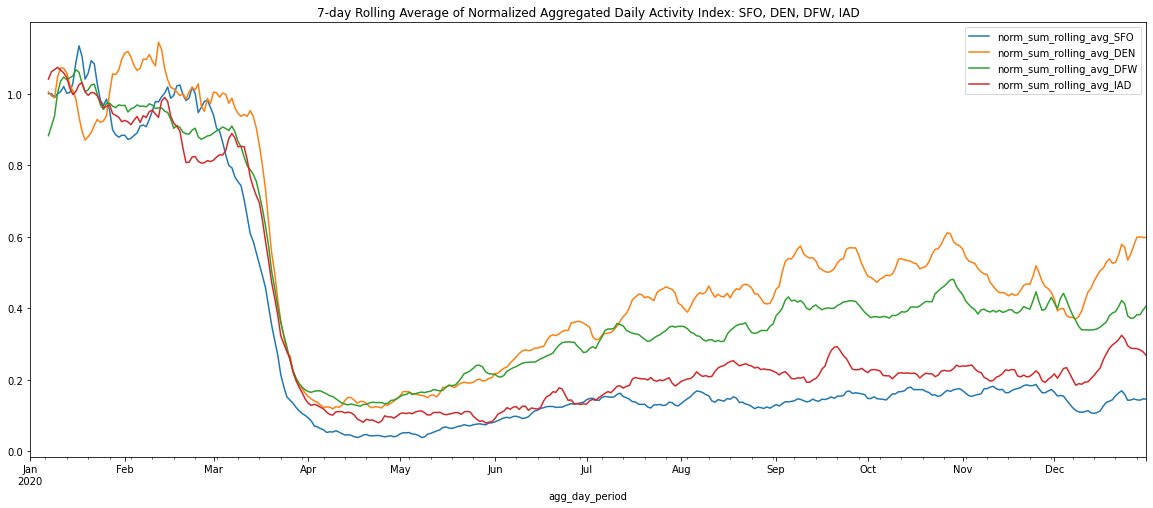

In [29]:
all_airports_norm_rolling = all_airports_stats_ai_df[[sum_col for sum_col in all_airports_stats_ai_df.columns if 'norm_sum_rolling' in sum_col]]
all_airports_norm_rolling.plot(figsize=(20, 8))
plt.legend(all_airports_norm_rolling.columns, loc='upper right')
plt.title('7-day Rolling Average of Normalized Aggregated Daily Activity Index: SFO, DEN, DFW, IAD')

In [30]:
# end of main tutorial
# end of main tutorial
# end of main tutorial

# Appendix II: Compute the adjusted daily average activity index for all z18 quadkeys

In [31]:
import matplotlib.pyplot as plt
## Generate adjusted daily stats for all four airport, append them to a list and create a DataFrame
all_airports_stats_ai = []
airports_dfDict = {"sfo": [sfo, z18_sample_data_sfo_df], "den": [den, z18_sample_data_den_df], "dfw": [dfw, z18_sample_data_dfw_df], "iad": [iad, z18_sample_data_iad_df]}

for airport_iad, airport_DFs in airports_dfDict.items():
    main_airport_df, airport_z18_sample_df = airport_DFs
    iata = main_airport_df['iata_code']
    airport_stats_ai = generate_airport_stats(airport_z18_sample_df)
    # Get the total number of z18 quadkeys that overlap the 1 km circle polygon
    total_num_z18_qks = float(len(set(main_airport_df['z18_quadkeys'])))

    # Calculate the adjusted daily average activity index. Add it as a new column to the stats DataFrame
    airport_stats_ai[f'adj_mean_ai_daily_{iata}'] = airport_stats_ai[f'sum_ai_daily_{iata}'] / total_num_z18_qks
    all_airports_stats_ai.append(airport_stats_ai)

# Create a large DataFrame to hold stats of all four airports
all_airports_stats_ai_df = pd.concat(all_airports_stats_ai, axis=1)

# Inspect the DataFrame
all_airports_stats_ai_df

,sum_ai_daily_SFO,normalized_sum_SFO,sum_ai_daily_rolling_avg_SFO,norm_sum_rolling_avg_SFO,adj_mean_ai_daily_SFO,sum_ai_daily_DEN,normalized_sum_DEN,sum_ai_daily_rolling_avg_DEN,norm_sum_rolling_avg_DEN,adj_mean_ai_daily_DEN,sum_ai_daily_DFW,normalized_sum_DFW,sum_ai_daily_rolling_avg_DFW,norm_sum_rolling_avg_DFW,adj_mean_ai_daily_DFW,sum_ai_daily_IAD,normalized_sum_IAD,sum_ai_daily_rolling_avg_IAD,norm_sum_rolling_avg_IAD,adj_mean_ai_daily_IAD
agg_day_period,,,,,,,,,,,,,,,,,,,,
2020-01-01,5.029205,0.843834,NaN,NaN,0.016435,8.947746,1.050325,NaN,NaN,0.027617,19.653429,0.726105,NaN,NaN,0.076771,5.647360,0.923460,NaN,NaN,0.017430
2020-01-02,6.479782,1.087222,NaN,NaN,0.021176,9.970132,1.170337,NaN,NaN,0.030772,25.818333,0.953871,NaN,NaN,0.100853,6.129980,1.002378,NaN,NaN,0.018920
2020-01-03,5.924845,0.994111,NaN,NaN,0.019362,8.335129,0.978414,NaN,NaN,0.025726,23.116370,0.854045,NaN,NaN,0.090298,5.943424,0.971872,NaN,NaN,0.018344
2020-01-04,5.373597,0.901619,NaN,NaN,0.017561,7.386913,0.867108,NaN,NaN,0.022799,20.752611,0.766715,NaN,NaN,0.081065,5.687044,0.929949,NaN,NaN,0.017553
2020-01-05,6.844148,1.148358,NaN,NaN,0.022366,7.805538,0.916248,NaN,NaN,0.024091,24.350000,0.899622,NaN,NaN,0.095117,6.685583,1.093231,NaN,NaN,0.020635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.985882,0.165418,0.871589,0.146241,0.003222,5.144558,0.603891,4.906665,0.575966,0.015878,11.627733,0.429592,10.096193,0.373009,0.045421,1.824389,0.298325,1.757398,0.287371,0.005631
2020-12-28,0.959070,0.160919,0.856824,0.143764,0.003134,6.186331,0.726178,5.097324,0.598346,0.019094,12.718722,0.469899,10.338095,0.381946,0.049683,1.608694,0.263055,1.755211,0.287013,0.004965
2020-12-29,0.816198,0.136947,0.850811,0.142755,0.002667,5.280610,0.619861,5.112940,0.600179,0.016298,10.895410,0.402536,10.337128,0.381910,0.042560,1.534017,0.250843,1.734220,0.283581,0.004735


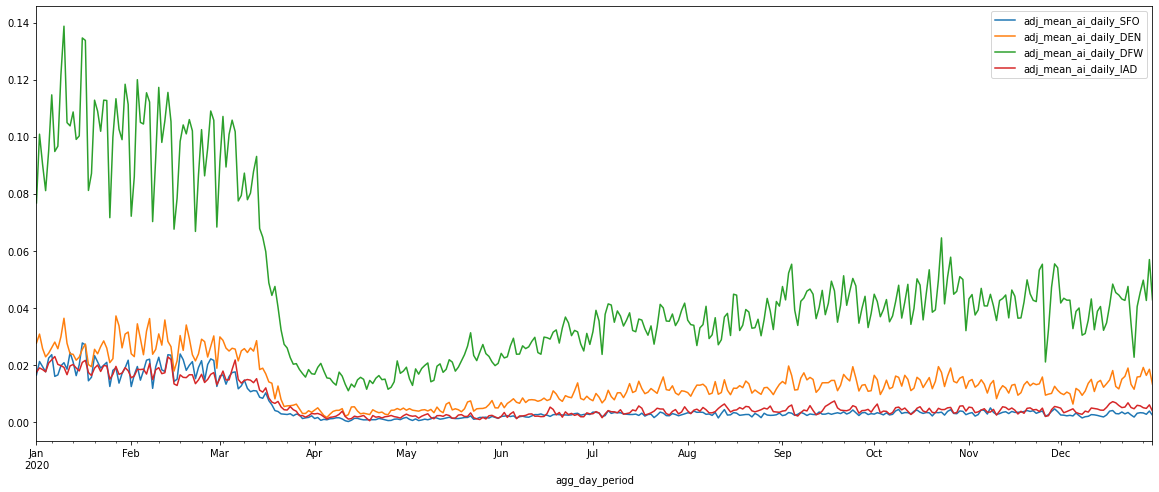

In [32]:
## Plot all airport adjusted daily aggregated mean
all_adj_mean = all_airports_stats_ai_df[[col for col in all_airports_stats_ai_df.columns if 'adj_mean' in col]]

all_adj_mean.plot(figsize=(20,8))
plt.legend(all_adj_mean, loc='upper right')

# Appendix III : Deep Dive into Approximate vs. Precise Airport Boundaries

## Step 1: Create a function that generates new boundaries for a given airport

In [33]:
import numpy as np

def generate_new_circles(
    airport,
    center_r=np.round(np.arange(-0.01, 0.015, 0.005), 3),
    size_r=np.arange(1000, 2500, 500)):
    """
    Given the following arguments, generate new circles of type
    Shapely.Polygon and creates a kepler map object.

    Args:
        airport (pandas.core.series.Series): a specific airport (row) from
            the original airports DataFrame.
        center_r (numpy.ndarray or list): numpy array or list of floats.
            Specifies the degrees to shift the center coordinates of the circles.
        size_r (numpy.ndarray or list): numpy array or list of integers.
            Specifies the radii of the circles.
    
    Returns:
        a dictionary of new circle Shapely Polygon objects and a kepler
        interactive map object.
    """
    # Get the center (Shapely Point) and circle (Shapely Polygon) of the airport
    circle_center = airport["airport_center"]
    circle_poly = airport["aeqd_reproj_circle"]

    # Define the GeoJSON object for the 1 km circle
    circle_feature = {
        "type": "Feature",
        "properties": {"name": "Circle"},
        "geometry": mapping(circle_poly)
    }

    # Define the GeoJSON object for the center of the circle
    center_feature = {
        "type": "Feature",
        "properties": {"name": "Center"},
        "geometry": mapping(circle_center)
    }

    # Define the Kepler map configurations
    config = {
        'version': 'v1',
        'config': {
            'mapState': {
                'latitude': airport["latitude_deg"],
                'longitude': airport["longitude_deg"],
                'zoom': 12
            }
        }
    }

    # Create a kepler map object of the original circle
    circle_map = KeplerGl(data={'Orig_Circle': circle_feature})
    circle_map.config = config
    circle_map.add_data(data=center_feature, name='Orig_Center')
    
    if type(center_r) is np.ndarray:
        center_r = center_r.tolist()
    
    if type(size_r) is np.ndarray:
        size_r = size_r.tolist()
    
    print (f'center shifts: {center_r}')
    print (f'circle sizes: {size_r}')
    
    new_circles = {}
    if 0.0 not in center_r:
        if 1000 not in size_r:
            new_circles[f'xy_0.0_1000'] = circle_poly_x

    for dist in center_r:
        for size in size_r:
            # Generates a new circle by shifting in the longitude X direction
            new_center_x = Point(circle_center.x - dist, circle_center.y)
            new_circle_poly_x = aeqd_reproj_buffer(new_center_x, radius=size)
            # Generates a new circle by shifting in the latitude Y direction
            new_center_y = Point(circle_center.x, circle_center.y - dist)
            new_circle_poly_y = aeqd_reproj_buffer(new_center_y, radius=size)

            # Define the GeoJSON object for the center of the new circle shifted in the longitude X direction
            new_center_feature_x = {
                "type": "Feature",
                "properties": {f"name": f"New Center_{dist}"},
                "geometry": mapping(new_center_x)
            }

            # Define the GeoJSON object for the new circle shifted in the longitude X direction
            new_circle_feature_x = {
                "type": "Feature",
                "properties": {"name": f"New Circle_{dist}_{size}"},
                "geometry": mapping(new_circle_poly_x)
            }
    
            # Define the GeoJSON object for the center of the new circle shifted in the latitude Y direction
            new_center_feature_y = {
                "type": "Feature",
                "properties": {f"name": f"New Center_{dist}"},
                "geometry": mapping(new_center_y)
            }
            
            # Define the GeoJSON object for the new circle shifted in the latitude Y direction
            new_circle_feature_y = {
                "type": "Feature",
                "properties": {"name": f"New Circle_{dist}_{size}"},
                "geometry": mapping(new_circle_poly_y)
            }
            
            if dist == 0.0:
                # Adds new circles with the same center coordinates as the original 1 km circle to the dictionary
                new_circles[f'xy_{dist}_{size}'] = new_circle_poly_x
                circle_map.add_data(data=new_center_feature_x, name=f'Center_{dist}_xy')
                circle_map.add_data(data=new_circle_feature_x, name=f'Circle_{dist}_xy_{size}')
            else:
                # Adds new circles to the dictionary
                new_circles[f'x_{dist}_{size}'] = new_circle_poly_x
                new_circles[f'y_{dist}_{size}'] = new_circle_poly_y
                
                # Adds new circles to the kepler map object
                circle_map.add_data(data=new_center_feature_x, name=f'Center_{dist}_x')
                circle_map.add_data(data=new_circle_feature_x, name=f'Circle_{dist}_x_{size}')
                circle_map.add_data(data=new_center_feature_y, name=f'Center_{dist}_y')
                circle_map.add_data(data=new_circle_feature_y, name=f'Circle_{dist}_y_{size}')

    print (f'{len(new_circles)} new circles generated')
    return new_circles, circle_map

### Create a function that generates statistics for all new boundaries

In [34]:
from datetime import timedelta, datetime

def generate_daily_stats_circles(
    airport,
    sample_data_df,
    center_r=np.round(np.arange(-0.01, 0.015, 0.005), 3),
    size_r=np.arange(1000, 2500, 500),
    prec_geo=None,
    verbose=False
):
    """
    Creates a DataFrame that holds all statistics of the original aiport
    1 km circle boundary and statistics of all newly generated boundaries (e.g. new
    circles, precise boundary). Also returns a kepler map object all of boundaries
    drawn.
    
    Args:
        airport (pandas.core.series.Series): a specific airport (row) from
            the original airports DataFrame.
        sample_data_df(Pandas DataFrame): Z7 quadkey sample data DataFrame of an airport.
        center_r (numpy.ndarray or list): numpy array or list of floats.
            Specifies the degrees to shift the center coordinates of the circles.
        size_r (numpy.ndarray or list): numpy array or list of integers.
            Specifies the radii of the circles.
        prec_geo (Shapely.Polygon): an airport's precise boundaries as a Shapely.Polygon object.
        verbose (boolean): Print progress
   
     Returns:
         a DataFrame consists of aggregated daily activity, normalized aggregated
         daily activity, 7-day rolling average of aggregated daily activity, and
         7-day rolling average of normalized aggregated daily activity for all
         combinations of circles.
    """
    jan_start = '2020-01-04'
    jan_end = '2020-01-31'
        
    new_circles, new_circle_map = generate_new_circles(airport, center_r, size_r)
    new_z18_quadkeys = {}
    for k, v in new_circles.items():
        # Find zoom 18 quadkeys that overlap with new circle
        new_z18_quadkeys[k] = generate_quadkeys(v, 18)

    new_daily_stats_dfList = []
    for k,v in new_z18_quadkeys.items():
        # From Movement sample data, find zoom 18 quadkeys that overlap with new circle
        new_z18_sample_df = sample_data_df[sample_data_df["z18_quadkey"].isin([z18_qk for z18_qk in v])].sort_values(by=['agg_day_period', 'z18_quadkey'])

        if verbose:
            print(f'Generating statistics for new boundaries: {k}')
            
        # Get the iata code of the airport
        iata = airport['iata_code']
        # Calculate airport statistics for the zoom 18 quadkeys overlapping the new circles.
        # Append the new circle label and airport iata code as the column name, so that its stats are distinguishable from one another
        new_daily_stats_dfList.append(generate_airport_stats(new_z18_sample_df, f'{iata}_{k}'))
    new_daily_stats = pd.concat(new_daily_stats_dfList, axis=1)
  
    if prec_geo:
        print (f'Including stats for precise boundaries')
        # Find zoom 18 quadkeys that overlap with the precise boundary
        prec_z18_quadkeys = generate_quadkeys(prec_geo, 18)
        # From Movement sample data, find zoom 18 quadkeys that overlap with the precise boundary
        prec_z18_sample_df = sample_data_df[sample_data_df["z18_quadkey"].isin([z18_qk for z18_qk in prec_z18_quadkeys])].sort_values(by=['agg_day_period', 'z18_quadkey']).copy()

        # Get the IATA airport code
        prec_z18_sample_df['iata'] = airport['iata_code']
        # Calculate airport statistics for the zoom 18 quadkeys overlapping the precise boundary.
        # Append the "precise" label and airport iata code as the column name, so that its stats are distinguishable from others
        prec_daily_sum = generate_airport_stats(prec_z18_sample_df, f'{iata}_precise')
        prec_daily_sum.columns = [
        f'prec_{stats}' for stats in list(dict.fromkeys(prec_daily_sum.columns))
        ]
        # Join this DataFrame to the one generated for new circles
        new_daily_stats = new_daily_stats.join(prec_daily_sum)
        
        
    return new_daily_stats, new_circle_map   

### Create a function that plots all types of statistics

In [35]:
import matplotlib.pyplot as plt

def plot_daily_stats_curves(
    daily_stats_df,
    plot_type='norm',
    exclude_shifts=None,
    plot_group='circle',
    prec_geo=False,
    legend=False,
    show_max=True
):

    """
    Creates various versions of plots for given DataFrame

    Args:
        daily_stats_df_filter (Pandas DataFrame): a DataFrame consists of
            aggregated daily activity, normalized aggregated daily
            activity, 7-day rolling average of aggregated daily activity,
            and 7-day rolling average of normalized aggregated
            daily activity for all types of boundaries (circles, precise etc).
        plot_type (string): plot aggregated daily activity (sum), normalized 
            aggregated daily activity (norm), 7-day rolling average of aggregated
            daily activity (rolling_sum), or 7-day rolling average of normalized
            daily activity (rolling_norm).
        exclude_shifts (list): list of particular circles (strings) to exclude.
        plot_group (string): plot circles or precise boundaries.
        legend (boolean): show legend in the plot.
        show_max (boolean): show the legend of the circle with maximum statistic.
        
    Raises:
        ValueError: Exception raised if generate_daily_stats_circles 
            is not run with precise boundaries, but the plot_group includes the
            'precise' object.

    Returns:
        Matplotlib plot of the specified type ('sum', 'norm', 'rolling_sum', 'rolling_norm')
    
    """
    daily_stats_df_filter = daily_stats_df.copy()
    
    # Some checks on input parameter
    plot_types = ['sum', 'norm', 'rolling_sum', 'rolling_norm']
    if plot_type not in plot_types:
        raise ValueError("Invalid plot type. Expected one of: %s" % plot_types)
        
    plot_groups = ['circle', 'precise']
    if plot_group not in plot_groups:
        raise ValueError("Invalid plot groups. Expected one of: %s" % plot_groups)
        
        
    if prec_geo:
        if len([x for x in daily_stats_df_filter.columns if 'prec' in x]) < 1:
            raise ValueError("Must first run generate_daily_stats_circles with precision geometry" % plot_groups)

    if exclude_shifts:
        for shift in exclude_shifts:
            print (f'Excluding shift: {shift}')
            daily_stats_df_filter = daily_stats_df_filter[[sum_col for sum_col in daily_stats_df_filter.columns if shift not in sum_col]]
    
    # Find all daily aggregated activity columns
    all_sum = daily_stats_df_filter[[sum_col for sum_col in daily_stats_df_filter.columns if 'sum_ai_daily' in sum_col and 'rolling' not in sum_col]]
    # Find all 7-day rolling average of daily aggregated activity columns
    all_sum_rolling = daily_stats_df_filter[[sum_col for sum_col in daily_stats_df_filter.columns if 'sum_ai_daily' in sum_col and 'rolling' in sum_col]]
    # Find all normalized daily aggregated activity columns
    all_norm = daily_stats_df_filter[[sum_col for sum_col in daily_stats_df_filter.columns if 'norm' in sum_col and 'rolling' not in sum_col]]
    # Find all 7-day rolling average of normalized daily aggregated activity columns
    all_norm_rolling = daily_stats_df_filter[[sum_col for sum_col in daily_stats_df_filter.columns if 'norm' in sum_col and 'rolling' in sum_col]]


    if plot_type == 'norm':
        df_plot = all_norm
        
        if prec_geo:
            title = f'Normalized aggregated daily actity for precise boundaries, center shifts: {center_r.tolist()}, radii: {size_r}' 
        else:
            title = f'Normalized aggregated daily actity for center shifts: {center_r.tolist()}, radii: {size_r}'

    elif plot_type == 'rolling_norm':
        df_plot = all_norm_rolling
        
        if prec_geo:
            title= f'7-day rolling avg of normalized aggregated daily actity for precise boundaries, center shifts: {center_r.tolist()}, radii: {size_r}' 
        else:
            title = f'7-day rolling avg of normalized aggregated daily actity for center shifts: {center_r.tolist()}, radii: {size_r}' 
                        
            
    elif plot_type == 'rolling_sum':
        df_plot = all_sum_rolling
        
        if prec_geo:
            title= f'7-day rolling avg of aggregated daily activity for precise boundaries, center shifts: {center_r.tolist()}, radii: {size_r}' 
        else:
            title = f'7-day rolling avg of aggregated daily activity for center shifts: {center_r.tolist()}, radii: {size_r}' 
            
    elif plot_type == 'sum':
        df_plot = all_sum

        if prec_geo:
            title= f'Aggregated Daily Actity for precise boundaries, center shifts: {center_r.tolist()}, radii: {size_r}' 
        else:
            title = f'Aggregated Daily Actity for center shifts: {center_r.tolist()}, radii: {size_r}' 
        
    ax = df_plot.plot(figsize=(20, 8), legend=legend)

    if legend:
        # show only important legends
        handles, labels = ax.get_legend_handles_labels()
    
        if prec_geo:
            # show precise boundary label
            selected_handles = [handles[labels.index(sum_col)] for sum_col in df_plot.columns if 'prec' in sum_col or '_0.0_' in sum_col]
        else:
            # show original 1 km circle label
            selected_handles = [handles[labels.index(sum_col)] for sum_col in df_plot.columns if '_0.0_' in sum_col]

        if show_max:
            maxidx = df_plot.max().idxmax()
            # show the label of the maximum statistics
            selected_handles.append(handles[labels.index(maxidx)])
        ax.legend(handles=selected_handles, loc='upper right')

    plt.title(title)

## Denver International Airport (DEN) Example

### First get Z7 quadkey Movement sample data for DEN
This is not the same as z18_sample_data_den_df we've previously downloaded using the z18_sample_data_den_url in step 8. z18_sample_data_den_df consists only of data from Z18 quadkey that overlap with the original 1 km circle. Since we are now drawing new boundaries, we'll need the larger dataset consists of **All Z18 quadkey data** from the Z7 quadkey. In the interest of saving time, you can use the following `download_zipped_z7_sample_data_to_df()` function to download a zipped file consists of 2020-01-01 to 2020-12-31 Z7 sample data for SFO, DEN, DFW, and IAD. It then converts a specific airport's CSV file into a Pandas DataFrame. This entire process **takes ~7 mins and significantly cuts down runtime of this notebook**. Alternatively, You can also customize your own set of parameters (dates, airports etc) and run the `download_sample_data_to_df()` function in Step 7.

In [36]:
import os
import pandas as pd
import zipfile

def download_zipped_z7_sample_data_to_df(local_dir, airport_name='den', verbose=True):
    """
    Downloads zipped Movement Z7 quadkey of four airports to a local directory,
    then unpacks zip files into individual CSV files,
    stored in the specified directory and converts an airport's CSV file to 
    a Pandas DataFrame.
    
    Args:
        local_dir (str): local directory to save the zip files and its content.
        airport_name (str): Defaults to DEN (Denver International Airport)
        verbose (boolean): print download and unzipping status
        
    Raises:
        ValueError: Exception raised if airport name is not one of 'den',
            'dfw', 'sfo', 'iad'.
    
    Returns:
        A Pandas DataFrame consists of All Z18 quadkey data from the Z7 quadkey.
    
    
    """
    
    # Some checks on input parameters
    airport_names = ['den', 'dfw', 'sfo', 'iad']
    if airport_name not in airport_names:
        raise ValueError("Invalid airport name. Expected one of: %s" %airport_names)
    
    if not os.path.isdir(os.path.join(local_dir)):
        os.makedirs(local_dir)
     
    # If zip file already exists, skip to unzip step.
    local_zip_fname = os.path.join(local_dir, f'sample_data_df_{airport_name}.zip')
    if not os.path.isfile(local_zip_fname):
        bucket = "mapbox-movement-public-sample-dataset"
        airports_sample_data_url = f'https://{bucket}.s3.amazonaws.com/airports_dataset/data/sample_data_df_{airport_name}.zip'

        try: 
            # Requests the zip file
            res = requests.get(airports_sample_data_url)

            # Write response to file
            with open(local_zip_fname, "wb") as f:
                f.write(res.content)
            
            if verbose:
                print (f'Zip file downloaded to local directory : {local_zip_fname}')

        except requests.exceptions.RequestException as e:
            raise SystemExit(e)
            
    if verbose:
        print (f'Unzipping file to local directory: {local_dir}')

    # Unzip files
    with zipfile.ZipFile(local_zip_fname, 'r') as zip_ref:
        zip_ref.extractall(local_dir)
    
    # Read airport Z7 quadkey CSV file to DataFrame
    sample_data_df_path = os.path.join(local_dir, f'sample_data_df_{airport_name}.csv')
    # Read in quadkey columns as strings, so we leading zeros are kept

    if verbose:
        print (f'Creating DataFrame')
    
    sample_data_df = pd.read_csv(sample_data_df_path, parse_dates=['agg_day_period'],
                                     dtype={'activity_index_total': 'float',
                                            'geography': 'str',
                                            'z18_quadkey': 'str',
                                            'z7_quadkey': 'str'
                                           })

    return sample_data_df.sort_values(by=['agg_day_period', 'z18_quadkey'])

In [37]:
%%time

# Load DEN Z7 quadkey sample data. Note that we are loading the unfiltered DataFrame, which includes available data from all Z18 quadkeys
airports_sample_data_path = os.path.join(os.getcwd(), 'airports_sample_data')
sample_data_df_den = download_zipped_z7_sample_data_to_df(airports_sample_data_path)

Unzipping file to local directory: /Users/virginiang/Documents/Movement/BlogPostStaging/airports_sample_data
Creating DataFrame
CPU times: user 35.5 s, sys: 5.4 s, total: 40.9 s
Wall time: 47.5 s


In [38]:
# Inspect number of rows in the two DEN DataFrames (full vs. filtered)
print (sample_data_df_den.shape)
print (z18_sample_data_den_df.shape)

(9362200, 8)
(19343, 9)


In [39]:
# Inspect the DataFrame
sample_data_df_den

,geography,xlon,xlat,bounds,agg_day_period,activity_index_total,z18_quadkey,z7_quadkey
7576090,23101000132321131,-106.282425,40.728007,"-106.28311157226562,40.72748642299779,-106.281...",2020-01-01,0.030153,023101000132321131,0231010
7561836,23101000220200232,-106.871567,40.539373,"-106.87225341796875,40.53885152535465,-106.870...",2020-01-01,0.146416,023101000220200232,0231010
7580496,23101000220303221,-106.818008,40.532067,"-106.81869506835938,40.531545551348394,-106.81...",2020-01-01,0.041439,023101000220303221,0231010
7581379,23101000220303302,-106.813889,40.533111,"-106.8145751953125,40.532589310695556,-106.813...",2020-01-01,0.043731,023101000220303302,0231010
7575048,23101000222000333,-106.864700,40.505968,"-106.86538696289062,40.50544628405211,-106.864...",2020-01-01,0.027589,023101000222000333,0231010
...,...,...,...,...,...,...,...,...
9127706,23101033302212100,-104.385910,38.984499,"-104.3865966796875,38.983965305617666,-104.385...",2020-12-31,0.040991,023101033302212100,0231010
9121194,23101033311011310,-104.108505,39.091167,"-104.10919189453125,39.090633742031436,-104.10...",2020-12-31,0.018048,023101033311011310,0231010
9113889,23101033312122123,-104.186783,38.998375,"-104.18746948242188,38.99784130750071,-104.186...",2020-12-31,0.135470,023101033312122123,0231010
9111826,23101033322220310,-104.405136,38.834894,"-104.40582275390625,38.83435910650903,-104.404...",2020-12-31,0.023561,023101033322220310,0231010


In [40]:
%%time

# set range of degrees to shift the new circle centers
center_r = np.round(np.arange(-0.01, 0.015, 0.005), 3)
# set range of new circle radii
size_r = [1000, 1500, 2000]

# Generate new circles, stats for each circle and create a kepler map object
den_new_daily_stats, den_new_circle_map = generate_daily_stats_circles(den, sample_data_df_den, center_r, size_r, None)

# Load keplergl map
den_new_circle_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
center shifts: [-0.01, -0.005, 0.0, 0.005, 0.01]
circle sizes: [1000, 1500, 2000]
27 new circles generated
CPU times: user 24.2 s, sys: 508 ms, total: 24.7 s
Wall time: 25.7 s


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 39.861698150635, 'longitude': -104.67299…

In [41]:
# Inspect the DataFrame
den_new_daily_stats

,sum_ai_daily_DEN_x_-0.01_1000,normalized_sum_DEN_x_-0.01_1000,sum_ai_daily_rolling_avg_DEN_x_-0.01_1000,norm_sum_rolling_avg_DEN_x_-0.01_1000,sum_ai_daily_DEN_y_-0.01_1000,normalized_sum_DEN_y_-0.01_1000,sum_ai_daily_rolling_avg_DEN_y_-0.01_1000,norm_sum_rolling_avg_DEN_y_-0.01_1000,sum_ai_daily_DEN_x_-0.01_1500,normalized_sum_DEN_x_-0.01_1500,...,sum_ai_daily_rolling_avg_DEN_y_0.01_1500,norm_sum_rolling_avg_DEN_y_0.01_1500,sum_ai_daily_DEN_x_0.01_2000,normalized_sum_DEN_x_0.01_2000,sum_ai_daily_rolling_avg_DEN_x_0.01_2000,norm_sum_rolling_avg_DEN_x_0.01_2000,sum_ai_daily_DEN_y_0.01_2000,normalized_sum_DEN_y_0.01_2000,sum_ai_daily_rolling_avg_DEN_y_0.01_2000,norm_sum_rolling_avg_DEN_y_0.01_2000
agg_day_period,,,,,,,,,,,,,,,,,,,,,
2020-01-01,6.639587,1.150990,NaN,NaN,1.597698,1.068831,NaN,NaN,15.370391,1.002959,...,NaN,NaN,17.014056,1.000025,NaN,NaN,21.961098,0.984822,NaN,NaN
2020-01-02,6.999524,1.213386,NaN,NaN,1.777456,1.189085,NaN,NaN,17.628361,1.150297,...,NaN,NaN,19.561378,1.149748,NaN,NaN,26.341062,1.181236,NaN,NaN
2020-01-03,5.574288,0.966318,NaN,NaN,1.617636,1.082169,NaN,NaN,15.053066,0.982253,...,NaN,NaN,16.667923,0.979681,NaN,NaN,22.110697,0.991530,NaN,NaN
2020-01-04,4.816627,0.834975,NaN,NaN,1.265511,0.846604,NaN,NaN,13.291337,0.867295,...,NaN,NaN,14.661485,0.861750,NaN,NaN,19.268686,0.864083,NaN,NaN
2020-01-05,5.582362,0.967718,NaN,NaN,1.498725,1.002620,NaN,NaN,15.182383,0.990691,...,NaN,NaN,17.064192,1.002972,NaN,NaN,23.084063,1.035180,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,3.748680,0.649844,3.419582,0.592794,1.013560,0.678053,0.928726,0.621301,8.661983,0.565217,...,8.594108,0.469881,9.092144,0.534404,8.060316,0.473757,11.890675,0.533224,10.375136,0.465262
2020-12-28,4.341963,0.752691,3.527468,0.611496,1.304890,0.872947,0.986256,0.659787,9.446540,0.616412,...,8.892527,0.486197,10.047798,0.590574,8.354554,0.491051,13.272296,0.595182,10.809577,0.484744
2020-12-29,3.483611,0.603893,3.507165,0.607976,0.999867,0.668893,0.998905,0.668249,8.111238,0.529280,...,8.878887,0.485451,8.590988,0.504948,8.346192,0.490559,11.096212,0.497598,10.784348,0.483612


Excluding shift: y_-0.01
CPU times: user 183 ms, sys: 7.66 ms, total: 191 ms
Wall time: 198 ms


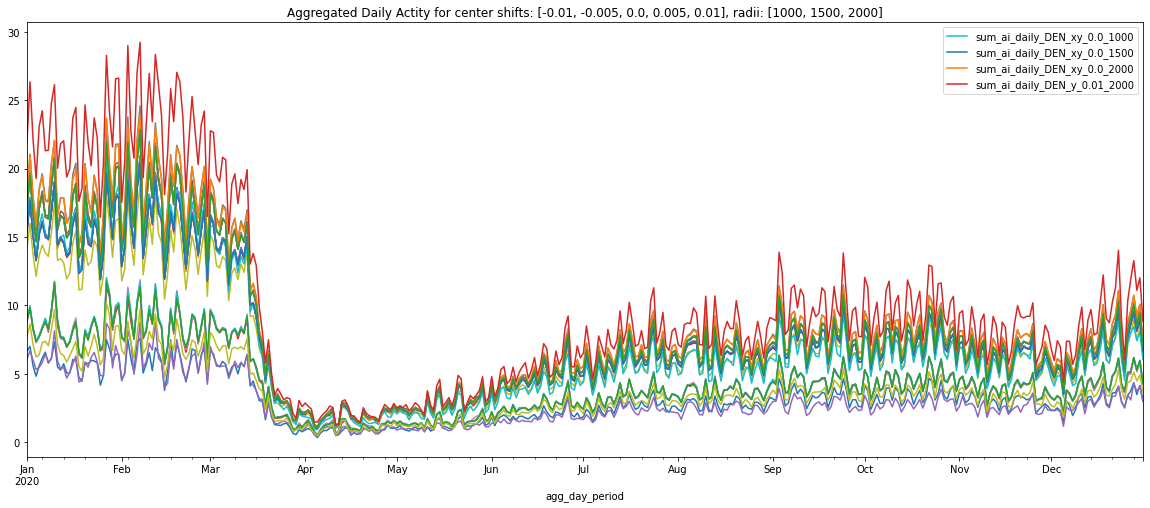

In [42]:
%%time

# Plot aggregated daily activity and exclude circle that overlaps with highway
plot_type = 'sum'
exclude_shifts= ['y_-0.01']

# Create a plot with selected labels. Show label with max value
plot_daily_stats_curves(
    den_new_daily_stats,
    plot_type,
    exclude_shifts,
    legend=True,
    show_max=True
)

CPU times: user 236 ms, sys: 5.97 ms, total: 242 ms
Wall time: 347 ms


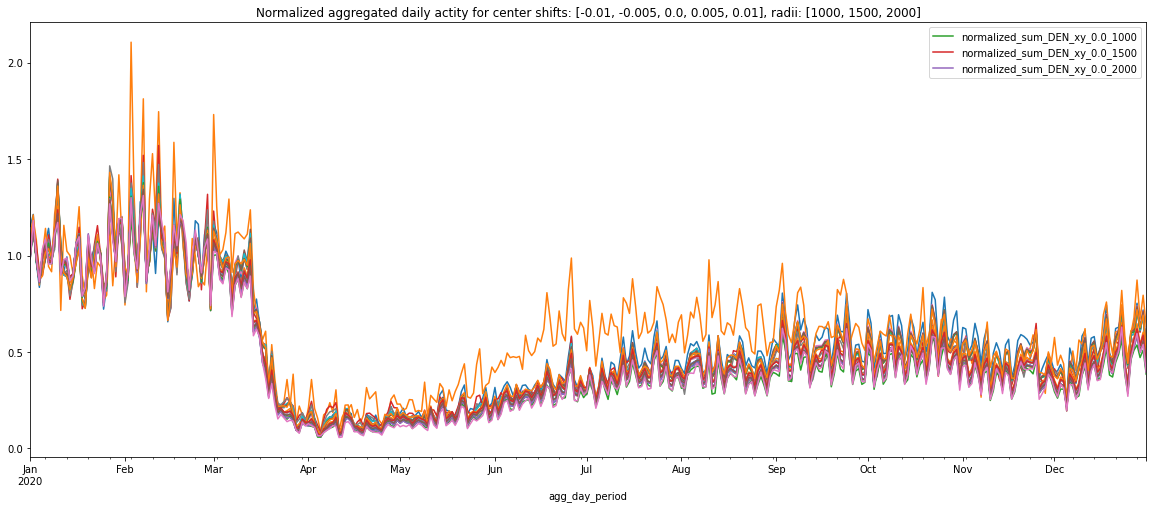

In [43]:
%%time

# Plot normalized aggregated daily activity
plot_type='norm'
exclude_shifts=None
plot_group = 'circle'

# Create a plot with selected labels. Show label with max value
plot_daily_stats_curves(
    den_new_daily_stats,
    plot_type,
    exclude_shifts,
    plot_group = 'circle',
    prec_geo=False,
    legend=True,
    show_max=False
)

Excluding shift: y_-0.01
CPU times: user 168 ms, sys: 4.14 ms, total: 172 ms
Wall time: 172 ms


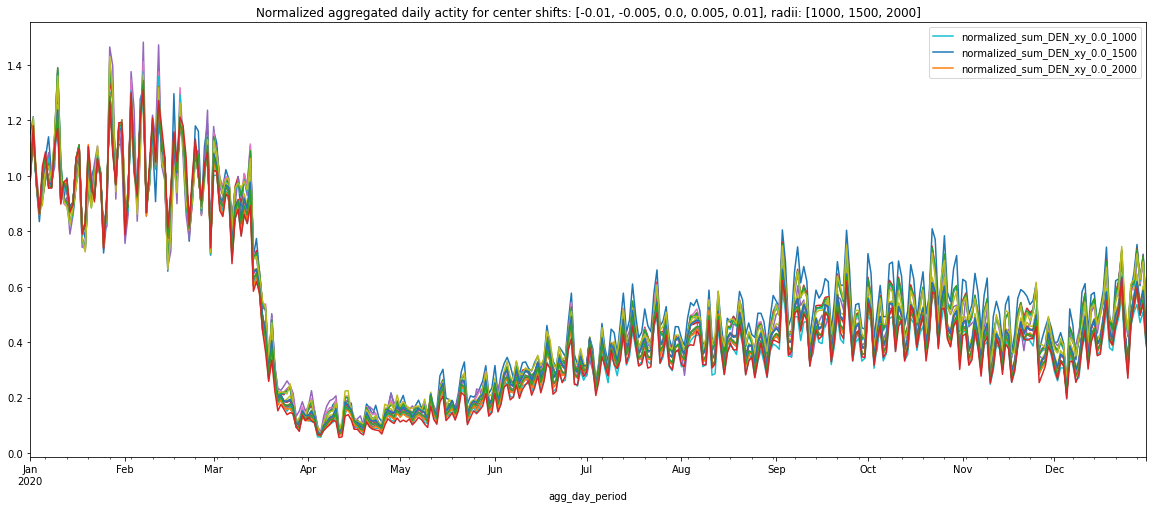

In [44]:
%%time

# Plot normalized aggregated daily activity and exclude circle that overlaps with highway
plot_type = 'norm'
exclude_shifts = ['y_-0.01']
plot_group = 'circle'

# Create a plot with selected labels. Show label with max value
plot_daily_stats_curves(
    den_new_daily_stats,
    plot_type,
    exclude_shifts,
    plot_group = 'circle',
    prec_geo=False,
    legend=True,
    show_max=False
)

### Try circle sizes 1000, 1200, 1500, 2000 meters

In [45]:
%%time

# set range of degrees to shift the new circle centers
center_r = np.round(np.arange(-0.01, 0.015, 0.005), 3)
# set range of new circle radii
size_r = [1000, 1200, 1500, 2000]

# Generate new circles, stats for each circle and create a kepler map object.
new_circles_den_daily_stats, new_circle_map_den = generate_daily_stats_circles(den, sample_data_df_den, center_r, size_r)
# Load keplergl map
new_circle_map_den

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
center shifts: [-0.01, -0.005, 0.0, 0.005, 0.01]
circle sizes: [1000, 1200, 1500, 2000]
36 new circles generated
CPU times: user 29.4 s, sys: 508 ms, total: 29.9 s
Wall time: 30.7 s


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 39.861698150635, 'longitude': -104.67299…

Excluding shift: y_-0.01


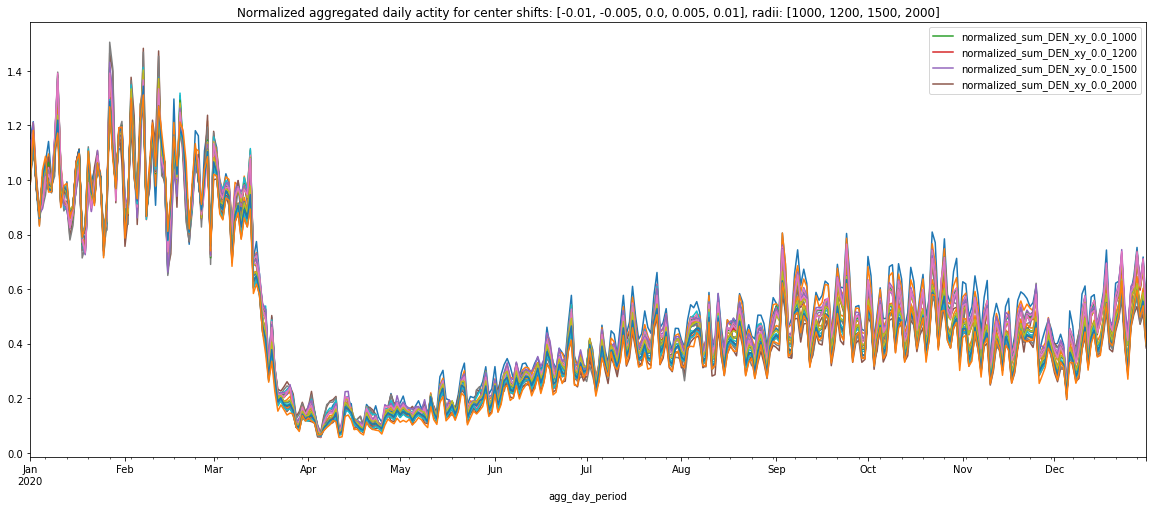

In [46]:
# Plot normalized aggregated daily activity and exclude circle that overlaps with highway
plot_type='norm'
exclude_shifts = ['y_-0.01']
plot_group = 'circle'

# Create a plot with selected labels. Show label with max value
plot_daily_stats_curves(
    new_circles_den_daily_stats,
    plot_type,
    exclude_shifts,
    plot_group = 'circle',
    prec_geo=False,
    legend=True,
    show_max=False
)

## Use Precise Boundaries of DEN

In [47]:
import requests
from io import StringIO
import json
from shapely.geometry import shape

def download_geojson(url, local_dir=os.getcwd(), verbose=False):
    """
    Given a url, downloads and reads the GeoJSON to a
    Shapely shape object. For more information about this object, see
    https://shapely.readthedocs.io/en/stable/manual.html#shapely.geometry.shape.
    
    Args:
        url (string): includes a protocol (http), a hostname (www.example.com),
            and a file name (index. html.
        local_dir (string): local directory to store downloaded boundaries.
        verbose (boolean): Print download status.
            
    Raises:
        requests.exceptions.RequestException: An exception raised while
            handling your request.
        
    Returns:
        a Shapely shape object.
    """
    if not os.path.isdir(os.path.join(local_dir)):
        os.makedirs(local_dir)

    # If geojson file already exists, skip download from S3 step.
    local_fname = os.path.join(local_dir, f'precise_boundaries.geojson')
    if not os.path.isfile(local_fname):
        try:
            res = requests.get(url)
            if verbose:
                print (f'Downloaded precise boundaries file to {local_fname}.')

        except requests.exceptions.RequestException as e:
            raise SystemExit(e)

        # Import Precise Boundaries of DEN
        with open(local_fname, "wb") as f:
            f.write(res.content)
    else:
        if verbose:
            print (f'Download step skipped. Precise boundaries file already exists as {local_fname}.')

    with open (local_fname) as f:
        feat = json.load(f)["features"][0]
        geom = shape(feat['geometry'])

    return geom

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
center shifts: [-0.01, -0.005, 0.0, 0.005, 0.01]
circle sizes: [1000, 1500, 2000]
27 new circles generated
Including stats for precise boundaries
Excluding shift: y_-0.01
CPU times: user 25.3 s, sys: 420 ms, total: 25.7 s
Wall time: 26.7 s


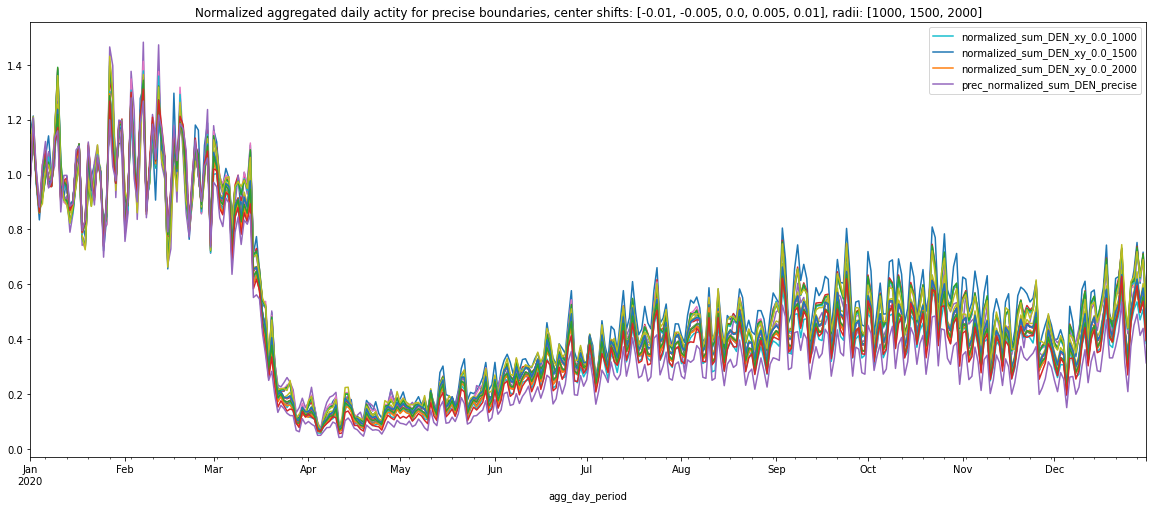

In [48]:
%%time

# set range of degrees to shift the new circle centers
center_r=np.round(np.arange(-0.01, 0.015, 0.005), 3)
# set range of new circle radii
size_r = [1000, 1500, 2000]
        
# Define the precision geometry
den_geo_url = 'https://mapbox-movement-public-sample-dataset.s3.amazonaws.com/airports_dataset/boundaries/precise_boundaries_denver.geojson'
den_geom=download_geojson(den_geo_url)
plot_type='norm'
plot_group='precise'
exclude_shifts = ['y_-0.01']

# Generate new circles, stats for each circle and create a kepler map object
prec_den_new_daily_stats, prec_den_new_map = generate_daily_stats_circles(den, sample_data_df_den, center_r, size_r, prec_geo=den_geom)

# plot normalized aggregated daily activity and exclude circle that overlaps with highway
plot_daily_stats_curves(
    prec_den_new_daily_stats,
    plot_type,
    exclude_shifts,
    plot_group,
    legend=True,
    prec_geo=True,
    show_max=False
)

### Try radius of 4000 meters overlaying precise boundaries stats

Download step skipped. Precise boundaries file already exists as /Users/virginiang/Documents/Movement/BlogPostStaging/test_dir2/precise_boundaries.geojson.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
center shifts: [-0.01, -0.005, 0.0, 0.005, 0.01]
circle sizes: [1000, 1500, 2000, 3000, 4000]
45 new circles generated
Including stats for precise boundaries
Excluding shift: y_-0.01
CPU times: user 43.6 s, sys: 726 ms, total: 44.4 s
Wall time: 45.7 s


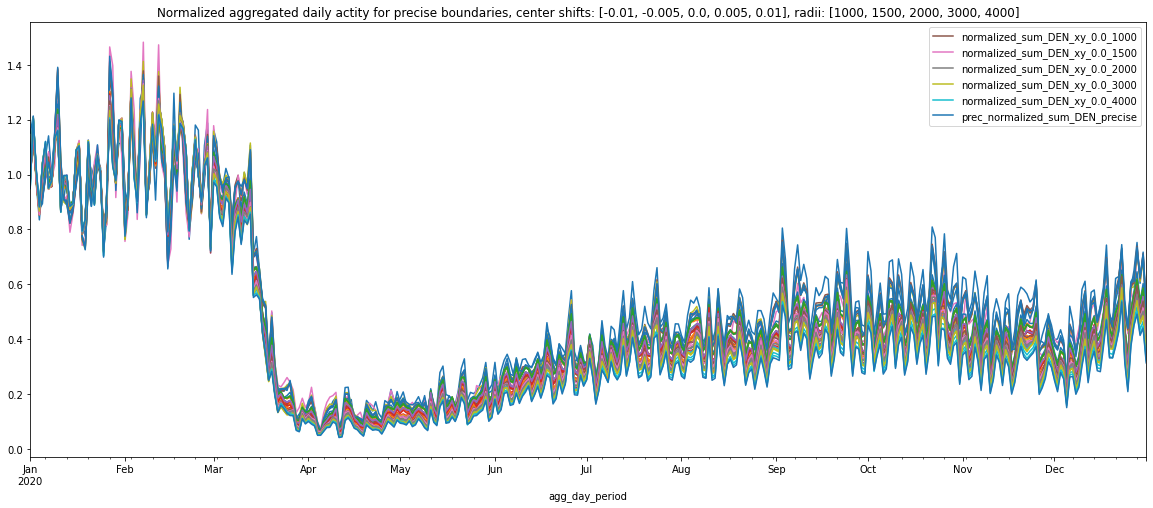

In [49]:
%%time

# set range of degrees to shift the new circle centers
center_r=np.round(np.arange(-0.01, 0.015, 0.005), 3)
# set range of new circle radii
size_r = [1000, 1500, 2000, 3000, 4000]
# Define the precision geometry
den_geo_url = 'https://mapbox-movement-public-sample-dataset.s3.amazonaws.com/airports_dataset/boundaries/precise_boundaries_denver.geojson'
# Test verbose and download to different directory
den_geom=download_geojson(den_geo_url, local_dir=os.path.join(os.getcwd(), 'test_dir2'), verbose=True)
plot_type='norm'
plot_group='precise'
exclude_shifts = ['y_-0.01']

# Generate new circles, stats for each circle and create a kepler map
prec_den_new_daily_stats, kepler_map = generate_daily_stats_circles(den, sample_data_df_den, center_r, size_r, prec_geo=den_geom)

# plot normalized aggregated daily activity and exclude circle that overlaps with highway
plot_daily_stats_curves(
    prec_den_new_daily_stats,
    plot_type,
    exclude_shifts,
    plot_group,
    legend=True,
    prec_geo=True,
    show_max=False
)

In [50]:
# End of Appendix
# End of Appendix
# End of Appendix

## Extra: Export Data to GeoJSON File

In [51]:
import json
import geopandas as gpd

def df2gpd(df, fields=""):
    """
    Converts a Pandas DataFrame into a GeoPandas DataFrame with Polygon Objects
    """
    geoms = []
    for c in df.bounds:
        try:
            pt = Point(json.loads(f"[{c}]"))
        except:
            assert np.isnan(c)
            pt = None
        geoms.append(pt)
        
    full_gpd = gpd.GeoDataFrame(df, geometry=geoms)

    return full_gpd[["geometry", "z18_quadkey", "iata", "agg_day_period", "activity_index_total"]].copy()

def save_gpd(gpdf, filepath, driver="GeoJSON"):
    """
    Saves a GeoPandas DataFrame to file
    """
    gpdf.to_file(filepath, driver=driver)
    return gpdf


def boundsToPolygon(bounds):
    """
    Given the bounds of a Shapely object, converts to Polygon
    """
    return [
        (bounds[0], bounds[1]),
        (bounds[2], bounds[1]),
        (bounds[2], bounds[3]),
        (bounds[0], bounds[3]),
        (bounds[0], bounds[1]),
      ]

def df2gpd_poly(df, fields=""):
    """
    Given a Pandas DataFrame, converts to GeoPandas DataFrame with Polygon Objects
    """
    geoms = []
    for c in df.bounds:
        try:
            poly = Polygon(boundsToPolygon(json.loads(f"[{c}]")))
        except:
            assert np.isnan(c)
            poly = None
        geoms.append(poly)
        
    full_gpd = gpd.GeoDataFrame(df, geometry=geoms)

    return full_gpd[["geometry", "z18_quadkey", "iata", "agg_day_period", "activity_index_total"]].copy()



In [52]:
sfo_df = airport_z18_sample_dfList[0]
sfo_df_march = sfo_df[(sfo_df["agg_day_period"] > '2020-03-01') & (sfo_df["agg_day_period"] < '2020-03-31')]
sfo_df_march.groupby(['agg_day_period']).sum()["activity_index_total"]
temp_save = df2gpd(sfo_df_march)
save_gpd(temp_save, "sfo_march_ai.geojson")
temp_save

,geometry,z18_quadkey,iata,agg_day_period,activity_index_total
2002,POINT (-122.38495 37.62728),23010221113120032,SFO,2020-03-02,0.035522
2003,POINT (-122.37671 37.62620),23010221113121200,SFO,2020-03-02,0.041044
2004,POINT (-122.38770 37.62076),23010221113122002,SFO,2020-03-02,0.039014
2005,POINT (-122.38770 37.61967),23010221113122020,SFO,2020-03-02,0.116310
2006,POINT (-122.38632 37.61967),23010221113122021,SFO,2020-03-02,0.026083
...,...,...,...,...,...
2663,POINT (-122.38358 37.61641),23010221113122213,SFO,2020-03-30,0.026395
2664,POINT (-122.38632 37.61532),23010221113122221,SFO,2020-03-30,0.030758
2665,POINT (-122.38632 37.61423),23010221113122223,SFO,2020-03-30,0.040860
2666,POINT (-122.38495 37.61532),23010221113122230,SFO,2020-03-30,0.048748


In [53]:
all_airport_df = pd.concat(airport_z18_sample_dfList)
temp_save = df2gpd(all_airport_df)
save_gpd(temp_save, "all_airports_2020_ai.geojson")

,geometry,z18_quadkey,iata,agg_day_period,activity_index_total
0,POINT (-122.38770 37.62402),23010221113120220,SFO,2020-01-01,0.057848
1,POINT (-122.37671 37.62620),23010221113121200,SFO,2020-01-01,0.061104
2,POINT (-122.38632 37.62076),23010221113122003,SFO,2020-01-01,0.026219
3,POINT (-122.38770 37.61967),23010221113122020,SFO,2020-01-01,0.138171
4,POINT (-122.38770 37.61858),23010221113122022,SFO,2020-01-01,0.131442
...,...,...,...,...,...
10367,POINT (-77.45087 38.94446),32010023330112212,IAD,2020-12-31,0.038573
10368,POINT (-77.44949 38.94446),32010023330112213,IAD,2020-12-31,0.027191
10369,POINT (-77.44812 38.94553),32010023330112300,IAD,2020-12-31,0.049599
10370,POINT (-77.44675 38.94553),32010023330112301,IAD,2020-12-31,0.058394
